In [4]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from scipy import stats
from scipy import integrate
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from brokenaxes import brokenaxes
import matplotlib.ticker as ticker

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def ACCR(i=0.05,n=20):
    return (i*((1+i)**n))/(((1+i)**n)-1)


def SpecPRecCost(flow, model, F, i=0.05, n=20, param=[]):
    # param = args
    if flow == 'LiquidManure' and model != 'Crystalactor':
        Cost = param[0] + param[1]*np.ceil(param[2]*F)*ACCR(i,n)*(1/F)
    elif flow == 'LiquidManure' and model == 'Crystalactor':
        Cost = param[0] + (param[1] + param[2]*np.ceil(param[3]*F))*np.ceil(param[4]*F)*ACCR(i,n)*(1/F)
    elif flow == 'SolidManure':
        Cost = param[0] + param[1]
    elif flow == 'PoultryLitter':
        Cost = param[0]
    elif flow == 'SlaughterhouseWasteLiquid':
        Cost = param[0] + param[1]*np.ceil(param[2]*F)*ACCR(i,n)*(1/F)
    elif flow == 'SlaughterhouseWasteSolid':
        Cost = param[0] + param[1]
    elif flow == 'WWTPLiquid':
        Cost = param[0]*((F/param[1])**param[2])*(1/F)
    elif flow == 'WWTPSludge':
        Cost = param[0]*((F/param[1])**param[2])*(1/F)
    elif flow == 'WWTPSSA':
        Cost = param[0] + param[1]
    elif flow == 'OFMSW':
        Cost = param[0] + param[1]
    else:
        raise ValueError('Flow no considered')
        
    return Cost
        


In [3]:
SpecPRecCost_Param = pd.read_csv('PRecvoeryCostPram.csv', sep=",", header=0, index_col=0)
SpecPRecCost_Param


Multiform-LiquidManure  Crystalactor-LiquidManure  Ostara Pearl 500-LiquidManure  Ostara Pearl 2K-LiquidManure  Ostara Pearl 10K-LiquidManure  Nuresys-LiquidManure  MAPHEX-LiquidManure  Multiform-SlaughterhouseWasteLiquid   Ostara Pearl 500-SlaughterhouseWasteLiquid  Ostara Pearl 2K-SlaughterhouseWasteLiquid  Ostara Pearl 10K-SlaughterhouseWasteLiquid  Crystalactor-WWTPLiquid  Ostara Pearl-WWTPLiquid  P RoC-WWTPLiquid  REMNUT-WWTPLiquid  AirPrex-WWTPLiquid  PRISA-WWTPLiquid  Stuttgart process-WWTPSludge  Gifhorn process-WWTPSludge  PHOXNAN-WWTPSludge  Aqua Reci-WWTPSludge  MEPHREC-WWTPSludge  EcoPhos-SolidManure  AshDec depollution-SolidManure  AshDec Rhenania-SolidManure  PASCH-SolidManure  LEACHPHOS-SolidManure  RecoPhos-SolidManure  Thermophos-SolidManure  Quick wash-PoultryLitter  EcoPhos-SlaughterhouseWasteSolid  AshDec depollution-SlaughterhouseWasteSolid  AshDec Rhenania-SlaughterhouseWasteSolid  PASCH-SlaughterhouseWasteSolid  \
Param or flow                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
RecoveryEfficiency            1.800000e-01               1.800000e-01                   1.800000e-01                  1.800000e-01                   1.800000e-01          1.800000e-01             0.180000                          1.800000e-01                                8.000000e-02                               8.000000e-02                                8.000000e-02                     0.38                     0.20              0.27               0.47                0.15              0.18                          0.40                        0.40                0.51                  0.61                0.68                 0.57                             0.6                          0.6               0.55                   0.54                  0.61                    0.57                       0.7                              0.71                                         0.74                                      0.74                            0.68   
param1                        2.570000e+01               3.530000e+00                   1.257000e+01                  1.257000e+01                   1.257000e+01          1.037000e+01           184.670000                          2.260000e+01                                1.560000e+01                               1.560000e+01                                1.560000e+01                305920.00                130856.00          75970.00          977933.00            74195.00         186923.00                     581730.00                   400384.00           891667.00             939605.00          1154473.00                 8.90                             8.9                          8.9               8.90                   8.90                  8.90                    8.90                       4.4                             14.60                                        14.60                                     14.60                           14.60   
param2                        1.100000e+06               2.300000e+06                   2.300000e+06                  3.100000e+06      

# Phosphorus recovered

# We are assuming SL separation is installed!!

### CattleCAFOs_Scenario1

In [4]:
# CattleCAFOs_Scenario1 = pd.read_csv('CAFOSSizesDistributions/Scenario1/CAFOs_Scenario1_df.csv', sep=",", header=0, index_col=0)

# ManureCattle = 33.0 #(kg/day/AU) Adjusted so that the results fit with the report, Fig 14
# PCattle = 0.08/100

# CattleCAFOs_Scenario1['kgPin/year'] = CattleCAFOs_Scenario1['Number of animals']*ManureCattle*365*PCattle

# CattleCAFOs_Scenario1


In [5]:
# PRecovery_CattleCAFOs_Scenario1 = CattleCAFOs_Scenario1.copy()

# PFlow_Type = 'LiquidManure'

# SpecPRecCost_Param_LiquidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_LiquidManure.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_CattleCAFOs_Scenario1[name + ' kgPrec/year'] = (PRecovery_CattleCAFOs_Scenario1['kgPin/year']*
#                                                               SpecPRecCost_Param_LiquidManure.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_CattleCAFOs_Scenario1[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CattleCAFOs_Scenario1[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_CattleCAFOs_Scenario1[name + ' EUR/year'] = PRecovery_CattleCAFOs_Scenario1[name + ' EUR/kgPrec']*PRecovery_CattleCAFOs_Scenario1[name + ' kgPrec/year']
    
# PFlow_Type = 'SolidManure'

# SpecPRecCost_Param_SolidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_SolidManure.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_CattleCAFOs_Scenario1[name + ' kgPrec/year'] = (PRecovery_CattleCAFOs_Scenario1['kgPin/year']*
#                                                               SpecPRecCost_Param_SolidManure.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_CattleCAFOs_Scenario1[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CattleCAFOs_Scenario1[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_CattleCAFOs_Scenario1[name + ' EUR/year'] = PRecovery_CattleCAFOs_Scenario1[name + ' EUR/kgPrec'] * PRecovery_CattleCAFOs_Scenario1[name + ' kgPrec/year']
    

# PRecovery_CattleCAFOs_Scenario1.to_csv('Results/PRecoveryAndCosts/PRecovery_CattleCAFOs_Scenario1.csv')
# PRecovery_CattleCAFOs_Scenario1

### CattleCAFOs_Scenario2

In [6]:
# CattleCAFOs_Scenario2 = pd.read_csv('CAFOSSizesDistributions/Scenario2/CAFOs_Scenario2_df.csv', sep=",", header=0, index_col=0)

# ManureCattle = 33.0 #(kg/day/AU) Adjusted so that the results fit with the report, Fig 14
# PCattle = 0.08/100

# CattleCAFOs_Scenario2['kgPin/year'] = CattleCAFOs_Scenario2['Number of animals']*ManureCattle*365*PCattle

# CattleCAFOs_Scenario2

In [7]:
# PRecovery_CattleCAFOs_Scenario2 = CattleCAFOs_Scenario2.copy()

# PFlow_Type = 'LiquidManure'

# SpecPRecCost_Param_LiquidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_LiquidManure.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_CattleCAFOs_Scenario2[name + ' kgPrec/year'] = (PRecovery_CattleCAFOs_Scenario2['kgPin/year']*
#                                                               SpecPRecCost_Param_LiquidManure.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_CattleCAFOs_Scenario2[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CattleCAFOs_Scenario2[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_CattleCAFOs_Scenario2[name + ' EUR/year'] = PRecovery_CattleCAFOs_Scenario2[name + ' EUR/kgPrec']* PRecovery_CattleCAFOs_Scenario2[name + ' kgPrec/year']
    
# PFlow_Type = 'SolidManure'

# SpecPRecCost_Param_SolidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_SolidManure.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_CattleCAFOs_Scenario2[name + ' kgPrec/year'] = (PRecovery_CattleCAFOs_Scenario2['kgPin/year']*
#                                                               SpecPRecCost_Param_SolidManure.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_CattleCAFOs_Scenario2[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CattleCAFOs_Scenario2[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_CattleCAFOs_Scenario2[name + ' EUR/year'] = PRecovery_CattleCAFOs_Scenario2[name + ' EUR/kgPrec']*PRecovery_CattleCAFOs_Scenario2[name + ' kgPrec/year']
    
# PRecovery_CattleCAFOs_Scenario2.to_csv('Results/PRecoveryAndCosts/PRecovery_CattleCAFOs_Scenario2.csv')

# PRecovery_CattleCAFOs_Scenario2

### SwineCAFOs_Scenario2

In [8]:
# SwineCAFOs_Scenario1 = pd.read_csv('CAFOSSizesDistributions/Swine/CAFOs_Scenario1_df.csv', sep=",", header=0, index_col=0)

# ManureSwine = 33.1 #(kg/day/AU) Adjusted so that the results fit with the report, Fig 14
# PSwine = 0.14/100

# SwineCAFOs_Scenario1['kgPin/year'] = SwineCAFOs_Scenario1['Number of animals']*ManureSwine*365*PSwine

# SwineCAFOs_Scenario1

In [9]:
# PRecovery_SwineCAFOs_Scenario1 = SwineCAFOs_Scenario1.copy()

# PFlow_Type = 'LiquidManure'

# SpecPRecCost_Param_LiquidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_LiquidManure.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_SwineCAFOs_Scenario1[name + ' kgPrec/year'] = (PRecovery_SwineCAFOs_Scenario1['kgPin/year']*
#                                                               SpecPRecCost_Param_LiquidManure.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_SwineCAFOs_Scenario1[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_SwineCAFOs_Scenario1[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_SwineCAFOs_Scenario1[name + ' EUR/year'] = PRecovery_SwineCAFOs_Scenario1[name + ' EUR/kgPrec']*PRecovery_SwineCAFOs_Scenario1[name + ' kgPrec/year']
    
# PFlow_Type = 'SolidManure'

# SpecPRecCost_Param_SolidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_SolidManure.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_SwineCAFOs_Scenario1[name + ' kgPrec/year'] = (PRecovery_SwineCAFOs_Scenario1['kgPin/year']*
#                                                               SpecPRecCost_Param_SolidManure.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_SwineCAFOs_Scenario1[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_SwineCAFOs_Scenario1[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_SwineCAFOs_Scenario1[name + ' EUR/year'] = PRecovery_SwineCAFOs_Scenario1[name + ' EUR/kgPrec']*PRecovery_SwineCAFOs_Scenario1[name + ' kgPrec/year']
    

# PRecovery_SwineCAFOs_Scenario1.to_csv('Results/PRecoveryAndCosts/PRecovery_SwineCAFOs_Scenario1.csv')

# PRecovery_SwineCAFOs_Scenario1

## CAFOs Ontario (Statistics Canada based)

In [10]:
LivestockType_list = ['Cattle',
                      'Swine',
                      'Poultry',
                      'Other']

for LivestockType in LivestockType_list:

    CAFOs_df = pd.read_csv('CAFOSSizesDistributions/OntarioData/CAFOs_' + LivestockType + '_df.csv', sep=",", header=0, index_col=0)

    PRecovery_CAFOs_df = CAFOs_df.copy()

    PFlow_Type = 'LiquidManure'

    SpecPRecCost_Param_LiquidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

    # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
    for tech in SpecPRecCost_Param_LiquidManure.columns:
        name = tech.rsplit('-')[0]
        PRecovery_CAFOs_df[name + ' kgPrec/year'] = (PRecovery_CAFOs_df['kgPin/year']*
                                                                  SpecPRecCost_Param_LiquidManure.loc['RecoveryEfficiency'][tech])

        TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

        PRecovery_CAFOs_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CAFOs_df[name + ' kgPrec/year'],
                                                                             i=0.05, n=20, param=TechParam)

        PRecovery_CAFOs_df[name + ' EUR/year'] = PRecovery_CAFOs_df[name + ' EUR/kgPrec']* PRecovery_CAFOs_df[name + ' kgPrec/year']

#     PFlow_Type = 'SolidManure'

#     SpecPRecCost_Param_SolidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

#     # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
#     for tech in SpecPRecCost_Param_SolidManure.columns:
#         name = tech.rsplit('-')[0]
#         PRecovery_CAFOs_df[name + ' kgPrec/year'] = (PRecovery_CAFOs_df['kgPin/year']*
#                                                                   SpecPRecCost_Param_SolidManure.loc['RecoveryEfficiency'][tech])

#         TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#         PRecovery_CAFOs_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CAFOs_df[name + ' kgPrec/year'],
#                                                                              i=0.05, n=20, param=TechParam)

#         PRecovery_CAFOs_df[name + ' EUR/year'] = PRecovery_CAFOs_df[name + ' EUR/kgPrec']*PRecovery_CAFOs_df[name + ' kgPrec/year']

    PRecovery_CAFOs_df.to_csv('Results/PRecoveryAndCosts/PRecovery_LiquidManure_'+ LivestockType + '.csv')

PRecovery_CAFOs_df

AUs  kgPin/year  Multiform kgPrec/year  Multiform EUR/kgPrec  Multiform EUR/year  Crystalactor kgPrec/year  Crystalactor EUR/kgPrec  Crystalactor EUR/year  Ostara Pearl 500 kgPrec/year  Ostara Pearl 500 EUR/kgPrec  Ostara Pearl 500 EUR/year  Ostara Pearl 2K kgPrec/year  Ostara Pearl 2K EUR/kgPrec  Ostara Pearl 2K EUR/year  Ostara Pearl 10K kgPrec/year  Ostara Pearl 10K EUR/kgPrec  Ostara Pearl 10K EUR/year  Nuresys kgPrec/year  Nuresys EUR/kgPrec  Nuresys EUR/year  MAPHEX kgPrec/year  MAPHEX EUR/kgPrec  MAPHEX EUR/year
0     15.714286  264.314923              47.576686           1880.954185        89489.566741                 47.576686              3882.699039          184725.953213                     47.576686                  3891.737842              185155.989482                    47.576686                 5241.013613             249350.059235                     47.576686                 16878.517137              803023.910851            47.576686         2337.870705     111228.140558           47.576686         690.648414      32858.76277
1     15.714286  264.314923              47.576686           1880.954185        89489.566741                 47.576686              3882.699039          184725.953213                     47.576686                  3891.737842              185155.989482                    47.576686                 5241.013613             249350.059235                     47.576686                 16878.517137              803023.910851            47.576686         2337.870705     111228.140558           47.576686         690.648414      32858.76277
2     15.714286  264.314923              47.576686           1880.954185        89489.566741                 47.576686              3882.699039          184725.953213                     47.576686                  3891.737842              185155.989482                    47.576686                 5241.013613             249350.059235                     47.576686                 16878.517137              803023.910851            47.576686         2337.870705     111228.140558           47.576686         690.648414      32858.76277
3     15.714286  264.314923              47.576686           1880.954185        89489.566741                 47.576686              3882.699039          184725.953213                     47.576686                  3891.737842              185155.989482                    47.576686                 5241.013613             249350.059235                     47.576686                 16878.517137              803023.910851            47.576686         2337.870705     111228.140558           47.576686         690.648414      32858.76277
4     15.714286  264.314923              47.576686           1880.954185        89489.566741                 47.576686              3882.699039          184725.953213                     47.576686                  3891.737842              185155.989482                    47.576686                 5241.013613             249350.059235                     47.576686                 16878.517137              803023.910851            47.576686         2337.870705     111228.140558           47.576686         690.648414      32858.76277
...         ...         ...                    ...                   ...                 ...                       ...                      ...                    ...                           ...                          ...                        ...                          ...                         ...                       ...                           ...                          ...                        ...                  ...                 ...               ...                 ...                ...              ...
8632  15.714286  264.314923              47.576686           1880.954185        89489.566741                 47.576686              3882.699039          184725.953213                     47.576686                  3891.737842              185155.989482 

In [11]:
LivestockType_list = ['Cattle',
                      'Swine',
                      'Poultry',
                      'Other']

for LivestockType in LivestockType_list:

    CAFOs_df = pd.read_csv('CAFOSSizesDistributions/OntarioData/CAFOs_' + LivestockType + '_df.csv', sep=",", header=0, index_col=0)

    PRecovery_CAFOs_df = CAFOs_df.copy()

#     PFlow_Type = 'LiquidManure'

#     SpecPRecCost_Param_LiquidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

#     # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
#     for tech in SpecPRecCost_Param_LiquidManure.columns:
#         name = tech.rsplit('-')[0]
#         PRecovery_CAFOs_df[name + ' kgPrec/year'] = (PRecovery_CAFOs_df['kgPin/year']*
#                                                                   SpecPRecCost_Param_LiquidManure.loc['RecoveryEfficiency'][tech])

#         TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#         PRecovery_CAFOs_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CAFOs_df[name + ' kgPrec/year'],
#                                                                              i=0.05, n=20, param=TechParam)

#         PRecovery_CAFOs_df[name + ' EUR/year'] = PRecovery_CAFOs_df[name + ' EUR/kgPrec']* PRecovery_CAFOs_df[name + ' kgPrec/year']

    PFlow_Type = 'SolidManure'

    SpecPRecCost_Param_SolidManure = SpecPRecCost_Param.filter(regex=PFlow_Type)

    # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
    for tech in SpecPRecCost_Param_SolidManure.columns:
        name = tech.rsplit('-')[0]
        PRecovery_CAFOs_df[name + ' kgPrec/year'] = (PRecovery_CAFOs_df['kgPin/year']*
                                                                  SpecPRecCost_Param_SolidManure.loc['RecoveryEfficiency'][tech])

        TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

        PRecovery_CAFOs_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_CAFOs_df[name + ' kgPrec/year'],
                                                                             i=0.05, n=20, param=TechParam)

        PRecovery_CAFOs_df[name + ' EUR/year'] = PRecovery_CAFOs_df[name + ' EUR/kgPrec']*PRecovery_CAFOs_df[name + ' kgPrec/year']

    PRecovery_CAFOs_df.to_csv('Results/PRecoveryAndCosts/PRecovery_SolidManure_'+ LivestockType + '.csv')

PRecovery_CAFOs_df

AUs  kgPin/year  EcoPhos kgPrec/year  EcoPhos EUR/kgPrec  EcoPhos EUR/year  AshDec depollution kgPrec/year  AshDec depollution EUR/kgPrec  AshDec depollution EUR/year  AshDec Rhenania kgPrec/year  AshDec Rhenania EUR/kgPrec  AshDec Rhenania EUR/year  PASCH kgPrec/year  PASCH EUR/kgPrec  PASCH EUR/year  LEACHPHOS kgPrec/year  LEACHPHOS EUR/kgPrec  LEACHPHOS EUR/year  RecoPhos kgPrec/year  RecoPhos EUR/kgPrec  RecoPhos EUR/year  Thermophos kgPrec/year  Thermophos EUR/kgPrec  Thermophos EUR/year
0     15.714286  264.314923           150.659506                13.4       2018.837378                      158.588954                           10.7                  1696.901802                   158.588954                        10.8               1712.760698         145.373207              13.6      1977.07562             142.730058                  14.0         1998.220814            161.232103                 11.4        1838.045971              150.659506                   11.6          1747.650268
1     15.714286  264.314923           150.659506                13.4       2018.837378                      158.588954                           10.7                  1696.901802                   158.588954                        10.8               1712.760698         145.373207              13.6      1977.07562             142.730058                  14.0         1998.220814            161.232103                 11.4        1838.045971              150.659506                   11.6          1747.650268
2     15.714286  264.314923           150.659506                13.4       2018.837378                      158.588954                           10.7                  1696.901802                   158.588954                        10.8               1712.760698         145.373207              13.6      1977.07562             142.730058                  14.0         1998.220814            161.232103                 11.4        1838.045971              150.659506                   11.6          1747.650268
3     15.714286  264.314923           150.659506                13.4       2018.837378                      158.588954                           10.7                  1696.901802                   158.588954                        10.8               1712.760698         145.373207              13.6      1977.07562             142.730058                  14.0         1998.220814            161.232103                 11.4        1838.045971              150.659506                   11.6          1747.650268
4     15.714286  264.314923           150.659506                13.4       2018.837378                      158.588954                           10.7                  1696.901802                   158.588954                        10.8               1712.760698         145.373207              13.6      1977.07562             142.730058                  14.0         1998.220814            161.232103                 11.4        1838.045971              150.659506                   11.6          1747.650268
...         ...         ...                  ...                 ...               ...                             ...                            ...                          ...                          ...                         ...                       ...                ...               ...             ...                    ...                   ...                 ...                   ...                  ...                ...                     ...                    ...                  ...
8632  15.714286  264.314923           150.659506                13.4       2018.837378                      158.588954                           10.7                  1696.901802                   158.588954                        10.8               1712.760698         145.373207              13.6      1977.07562             142.730058                  14.0         1998.220814            161.232103                 11.4        1838.045971 

### WWTPs Liquid This database just reports releases, not disposals, so we will create a new dataframe in cells below for it

In [12]:
#This database just reports releases, not disposals, so we will create a new dataframe in cells below for it
WWWTPsLiquid_Ontario_df = pd.read_csv('WWTPsData/wser_effluent (1).csv', sep=",", header=0, index_col=0) 

# Dropping decomissioned facilities and NaNs
WWWTPsLiquid_Ontario_df = WWWTPsLiquid_Ontario_df[(WWWTPsLiquid_Ontario_df['System status'] == 'operational') & (WWWTPsLiquid_Ontario_df['Y2019'] > 0)]
WWWTPsLiquid_Ontario_df = WWWTPsLiquid_Ontario_df.dropna(axis=0, subset=['Y2019'])

PWWTP_Liquid = 0.000452629303341566*1000 #kg/thousan m3; source: mwd.csv, the other table of Jorge

WWWTPsLiquid_Ontario_df['kgPin/year'] = WWWTPsLiquid_Ontario_df['Y2019']*PWWTP_Liquid

WWWTPsLiquid_Ontario_df

Owner Name                                        System Name                               City Province  Latitude  Longitude System status   CDUID                           CDNAME        Y2013        Y2014        Y2015        Y2016        Y2017        Y2018        Y2019        Units     kgPin/year
ID_WSER                                                                                                                                                                                                                                                                                                                                                     
375                                            Stelco Inc.                                          Lake Erie                   Haldimand County       ON   42.7940   -80.1090   operational  3528.0                Haldimand-Norfolk     162.3130     164.7630     135.9750     125.5630     161.7000     202.1250     187.6450  thousand m3      84.933626
503                        Regional Municipality of Durham                                  Duffin Creek WPCP                          Pickering       ON   43.8156   -79.0484   operational  3518.0                           Durham  125615.3020  125187.3930  116781.0590  116277.1300  121734.3420  125252.9370  124847.1070  thousand m3   56509.459066
1412                                        Bruce Power LP                                        Bruce Power                           Tiverton       ON   44.3233   -81.5875   operational  3541.0                            Bruce     376.6781     411.1270     411.6526     389.8714     391.9040     353.0745     340.7550  thousand m3     154.235698
1436                 The Corporation of the City of Barrie                     Water Pollution Control Centre                             Barrie       ON   44.3776   -79.6920   operational  3543.0                           Simcoe   18676.6950   18465.9400   17527.8700   17707.7790   18509.8430   18110.8980   18197.0700  thousand m3    8236.527117
7059                                        City of Sarnia                     Water Pollution Control Centre                             Sarnia       ON   42.9528   -82.4065   operational  3538.0                          Lambton    8504.6068    7976.2739    8365.6310    9427.2610   10084.1690   10682.9760   11979.8060  thousand m3    5422.411244
7391                        DEPARTMENT OF NATIONAL DEFENCE              4th Canadian Division Training Centre                            Meaford       ON   44.6653   -80.6754   operational  3542.0                             Grey     103.0550      96.5260      93.4260     113.8270     113.8650     112.5050     106.9140  thousand m3      48.392409
7890             The Corporation of the City of Belleville           Belleville Wastewater Treatment Facility                         Belleville       ON   44.1572   -77.3725   operational  3512.0                         Hastings    9264.7210   10250.0387    8143.5230    7614.1800   12558.3369   11844.7320   12071.0880  thousand m3    5463.728152
8469                         Canadian Nuclear Laboratories                           Chalk River Laboratories                        Chalk River       ON   46.0524   -77.3618   operational  3547.0                          Renfrew     207.0580     208.8070     210.0190     205.7020     227.4760     210.6520     166.0380  thousand m3      75.153664
8493          The Corporation of the Town of Kirkland Lake           Kirkland Lake Wastewater Treatment Plant                      Kirkland Lake       ON   48.1372   -80.0363   operational  3554.0                      Timiskaming    2981.9380    3228.6470    3246.8350    2629.0720    3309.3116    3332.0830    4116.5490  thousand m3    1863.270706
8983                                   City of Thunder Bay                      Water Pollution Control Plant                        Thunder Bay       ON   48.3964   -89.2259   operational  3558.0             

In [13]:
PRecovery_WWWTPsLiquid_Ontario_df = WWWTPsLiquid_Ontario_df.copy()

PFlow_Type = 'WWTPLiquid'

SpecPRecCost_Param_WWTPLiquid = SpecPRecCost_Param.filter(regex=PFlow_Type)

# for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
for tech in SpecPRecCost_Param_WWTPLiquid.columns:
    name = tech.rsplit('-')[0]
    PRecovery_WWWTPsLiquid_Ontario_df[name + ' kgPrec/year'] = (PRecovery_WWWTPsLiquid_Ontario_df['kgPin/year']*
                                                              SpecPRecCost_Param_WWTPLiquid.loc['RecoveryEfficiency'][tech])
    
    TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

    PRecovery_WWWTPsLiquid_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_WWWTPsLiquid_Ontario_df[name + ' kgPrec/year'],
                                                                         i=0.05, n=20, param=TechParam)
    
    PRecovery_WWWTPsLiquid_Ontario_df[name + ' EUR/year'] = PRecovery_WWWTPsLiquid_Ontario_df[name + ' EUR/kgPrec']*PRecovery_WWWTPsLiquid_Ontario_df[name + ' kgPrec/year']

PRecovery_WWWTPsLiquid_Ontario_df.to_csv('Results/PRecoveryAndCosts/PRecovery_WWWTPsLiquid_Ontario_df.csv')

PRecovery_WWWTPsLiquid_Ontario_df

Owner Name                                        System Name                               City Province  Latitude  Longitude System status   CDUID                           CDNAME        Y2013        Y2014        Y2015        Y2016        Y2017        Y2018        Y2019        Units     kgPin/year  Crystalactor kgPrec/year  Crystalactor EUR/kgPrec  Crystalactor EUR/year  Ostara Pearl kgPrec/year  Ostara Pearl EUR/kgPrec  Ostara Pearl EUR/year  P RoC kgPrec/year  P RoC EUR/kgPrec  P RoC EUR/year  REMNUT kgPrec/year  REMNUT EUR/kgPrec  REMNUT EUR/year  AirPrex kgPrec/year  AirPrex EUR/kgPrec  AirPrex EUR/year  PRISA kgPrec/year  PRISA EUR/kgPrec  PRISA EUR/year
ID_WSER                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
375                                            Stelco Inc.                                          Lake Erie                   Haldimand County       ON   42.7940   -80.1090   operational  3528.0                Haldimand-Norfolk     162.3130     164.7630     135.9750     125.5630     161.7000     202.1250     187.6450  thousand m3      84.933626                 32.274778               187.300115            6045.069580                 16.986725               702.795751           11938.198246          22.932079         18.500346      424.251392           39.918804          47.201415     1.884224e+03            12.740044          465.135137       5925.842043          15.288053        700.263871    10705.670906
503                        Regional Municipality of Durham                                  Duffin Creek WPCP                          Pickering       ON   43.8156   -79.0484   operational  3518.0                           Durham  125615.3020  125187.3930  116781.0590  116277.1300  121734.3420  125252.9370  124847.1070  thousand m3   56509.459066              21473.594445                13.034400          279895.412932              11301.891813                10.966867          123946.344166       15257.553948          4.427012    67545.377805        26559.445761          31.957480     8.487730e+05          8476.418860            8.265962      70065.759776       10171.702632         17.223764   175195.008381
1412                                        Bruce Power LP                                        Bruce Power                           Tiverton       ON   44.3233   -81.5875   operational  3541.0                            Bruce     376.6781     411.1270     411.6526     389.8714     391.9040     353.0745     340.7550  thousand m3     154.235698                 58.609565               146.657709            8595.544556                 30.847140               479.735408           14798.465115          41.643639         16.224701      675.655573           72.490778          45.541644     3.301349e+03            23.135355          321.317145       7433.786129          27.762426        498.392770    13836.592232
1436                 The Corporation of the City of Barrie                     Water Pollution Control Centre                             Barrie       ON   44.3776   -79.6920   operational  3543.0                           Simcoe   18676.6950   18465.9400   17527.8700   17707.7790   18509.8430   18110.8980   18197.0700  thousand m3    8236.527117               3129.880304                28.708177           89853.157018               1647.305423          

### WWTPs Sludge 

In [14]:
WWWTPsSludge_Ontario_df = pd.read_csv('WWTPsData/wser_effluent (1).csv', sep=",", header=0, index_col=0) 

# Dropping decomissioned facilities and NaNs
WWWTPsSludge_Ontario_df = WWWTPsSludge_Ontario_df[(WWWTPsSludge_Ontario_df['System status'] == 'operational') & (WWWTPsSludge_Ontario_df['Y2019'] > 0)]
WWWTPsSludge_Ontario_df = WWWTPsSludge_Ontario_df.dropna(axis=0, subset=['Y2019'])


PWWTP_Liquid = 0.000452629303341566*1000 #kg/thousan m3; source: mwd.csv, the other table of Jorge
P_LiquidFraction = 0.141
P_SludgeFraction = 0.859

WWWTPsSludge_Ontario_df['kgPin/year'] = (WWWTPsSludge_Ontario_df['Y2019']*PWWTP_Liquid*P_SludgeFraction)/P_LiquidFraction

WWWTPsSludge_Ontario_df

Owner Name                                        System Name                               City Province  Latitude  Longitude System status   CDUID                           CDNAME        Y2013        Y2014        Y2015        Y2016        Y2017        Y2018        Y2019        Units     kgPin/year
ID_WSER                                                                                                                                                                                                                                                                                                                                                     
375                                            Stelco Inc.                                          Lake Erie                   Haldimand County       ON   42.7940   -80.1090   operational  3528.0                Haldimand-Norfolk     162.3130     164.7630     135.9750     125.5630     161.7000     202.1250     187.6450  thousand m3     517.432514
503                        Regional Municipality of Durham                                  Duffin Creek WPCP                          Pickering       ON   43.8156   -79.0484   operational  3518.0                           Durham  125615.3020  125187.3930  116781.0590  116277.1300  121734.3420  125252.9370  124847.1070  thousand m3  344266.846364
1412                                        Bruce Power LP                                        Bruce Power                           Tiverton       ON   44.3233   -81.5875   operational  3541.0                            Bruce     376.6781     411.1270     411.6526     389.8714     391.9040     353.0745     340.7550  thousand m3     939.634502
1436                 The Corporation of the City of Barrie                     Water Pollution Control Centre                             Barrie       ON   44.3776   -79.6920   operational  3543.0                           Simcoe   18676.6950   18465.9400   17527.8700   17707.7790   18509.8430   18110.8980   18197.0700  thousand m3   50178.558819
7059                                        City of Sarnia                     Water Pollution Control Centre                             Sarnia       ON   42.9528   -82.4065   operational  3538.0                          Lambton    8504.6068    7976.2739    8365.6310    9427.2610   10084.1690   10682.9760   11979.8060  thousand m3   33034.406089
7391                        DEPARTMENT OF NATIONAL DEFENCE              4th Canadian Division Training Centre                            Meaford       ON   44.6653   -80.6754   operational  3542.0                             Grey     103.0550      96.5260      93.4260     113.8270     113.8650     112.5050     106.9140  thousand m3     294.816168
7890             The Corporation of the City of Belleville           Belleville Wastewater Treatment Facility                         Belleville       ON   44.1572   -77.3725   operational  3512.0                         Hastings    9264.7210   10250.0387    8143.5230    7614.1800   12558.3369   11844.7320   12071.0880  thousand m3   33286.116898
8469                         Canadian Nuclear Laboratories                           Chalk River Laboratories                        Chalk River       ON   46.0524   -77.3618   operational  3547.0                          Renfrew     207.0580     208.8070     210.0190     205.7020     227.4760     210.6520     166.0380  thousand m3     457.851047
8493          The Corporation of the Town of Kirkland Lake           Kirkland Lake Wastewater Treatment Plant                      Kirkland Lake       ON   48.1372   -80.0363   operational  3554.0                      Timiskaming    2981.9380    3228.6470    3246.8350    2629.0720    3309.3116    3332.0830    4116.5490  thousand m3   11351.415152
8983                                   City of Thunder Bay                      Water Pollution Control Plant                        Thunder Bay       ON   48.3964   -89.2259   operational  3558.0             

In [15]:
PRecovery_WWWTPsSludge_Ontario_df = WWWTPsSludge_Ontario_df.copy()

PFlow_Type = 'WWTPSludge' 

SpecPRecCost_Param_WWTPSludge = SpecPRecCost_Param.filter(regex=PFlow_Type)

# for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
for tech in SpecPRecCost_Param_WWTPSludge.columns:
    name = tech.rsplit('-')[0]
    PRecovery_WWWTPsSludge_Ontario_df[name + ' kgPrec/year'] = (PRecovery_WWWTPsSludge_Ontario_df['kgPin/year']*
                                                              SpecPRecCost_Param_WWTPSludge.loc['RecoveryEfficiency'][tech])
    
    TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

    PRecovery_WWWTPsSludge_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_WWWTPsSludge_Ontario_df[name + ' kgPrec/year'],
                                                                         i=0.05, n=20, param=TechParam)
    
    PRecovery_WWWTPsSludge_Ontario_df[name + ' EUR/year'] =  PRecovery_WWWTPsSludge_Ontario_df[name + ' EUR/kgPrec']*PRecovery_WWWTPsSludge_Ontario_df[name + ' kgPrec/year']
    
PFlow_Type = 'WWTPSSA'

SpecPRecCost_Param_WWTPSSA = SpecPRecCost_Param.filter(regex=PFlow_Type)

# for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
for tech in SpecPRecCost_Param_WWTPSSA.columns:
    name = tech.rsplit('-')[0]
    PRecovery_WWWTPsSludge_Ontario_df[name + ' kgPrec/year'] = (PRecovery_WWWTPsSludge_Ontario_df['kgPin/year']*
                                                              SpecPRecCost_Param_WWTPSSA.loc['RecoveryEfficiency'][tech])
    
    TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

    PRecovery_WWWTPsSludge_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_WWWTPsSludge_Ontario_df[name + ' kgPrec/year'],
                                                                         i=0.05, n=20, param=TechParam)
    
    PRecovery_WWWTPsSludge_Ontario_df[name + ' EUR/year'] = PRecovery_WWWTPsSludge_Ontario_df[name + ' EUR/kgPrec']*PRecovery_WWWTPsSludge_Ontario_df[name + ' kgPrec/year']
    

PRecovery_WWWTPsSludge_Ontario_df.to_csv('Results/PRecoveryAndCosts/PRecovery_WWWTPsSludge_Ontario_df.csv')

PRecovery_WWWTPsSludge_Ontario_df

Owner Name                                        System Name                               City Province  Latitude  Longitude System status   CDUID                           CDNAME        Y2013        Y2014        Y2015        Y2016        Y2017        Y2018        Y2019        Units     kgPin/year  Stuttgart process kgPrec/year  Stuttgart process EUR/kgPrec  Stuttgart process EUR/year  Gifhorn process kgPrec/year  Gifhorn process EUR/kgPrec  Gifhorn process EUR/year  PHOXNAN kgPrec/year  PHOXNAN EUR/kgPrec  PHOXNAN EUR/year  Aqua Reci kgPrec/year  Aqua Reci EUR/kgPrec  Aqua Reci EUR/year  MEPHREC kgPrec/year  MEPHREC EUR/kgPrec  MEPHREC EUR/year  EcoPhos kgPrec/year  EcoPhos EUR/kgPrec  EcoPhos EUR/year  AshDec depollution kgPrec/year  AshDec depollution EUR/kgPrec  AshDec depollution EUR/year  AshDec Rhenania kgPrec/year  AshDec Rhenania EUR/kgPrec  AshDec Rhenania EUR/year  PASCH kgPrec/year  PASCH EUR/kgPrec  PASCH EUR/year  \
ID_WSER                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
375                                            Stelco Inc.                                          Lake Erie                   Haldimand County       ON   42.7940   -80.1090   operational  3528.0                Haldimand-Norfolk     162.3130     164.7630     135.9750     125.5630     161.7000     202.1250     187.6450  thousand m3     517.432514                     206.973005                     37.714155                7.805812e+03                   206.973005                   36.435057              7.541073e+03           263.890582           57.764499      1.524351e+04             315.633833             56.068406        1.769709e+04           351.854109          170.905895      6.013394e+04           424.294661                12.5      5.303683e+03                      444.991962                            9.8                 4.360921e+03                   444.991962                         9.9              4.405420e+03         408.771686              12.7    5.191400e+03   
503                        Regional Municipality of Durham                                  Duffin Creek WPCP                          Pickering       ON   43.8156   -79.0484   operational  3518.0                           Durham  125615.3020  125187.3930  116781.0590  116277.1300  121734.3420  125252.9370  124847.1070  thousand m3  344266.846364                  137706.738546                     18.448872                2.540534e+06                137706.738546                   11.307640              1.557138e+06        175576.091646           20.416175      3.584592e+06          210002.776282             17.400861        3.654229e+06        234101.455528           13.544746      3.170845e+06        282298.814019                12.5      3.528735e+06                   296069.487873                            9.8                 2.901481e+06                296069.487873                         9.9              2.931088e+06      271970.808628              12.7    3.454029e+06   
1412                                        Bruce Power LP              

### Slaughterhouse

In [16]:
SlaughterhouseCattle_Facilities = 7
SlaughterhouseSwine_Facilities = 6
SlaughterhousePoultry_Facilities = 17

SlaughterhouseCattle_PFlow = 2222E3 #kg per year
SlaughterhouseSwine_PFlow = 621E3 #kg per year
SlaughterhousePoultry_PFlow = 904E3 #kg per year

Slaughterhouse_Ontario_df = pd.DataFrame(data={'Facilities':[SlaughterhouseCattle_Facilities,SlaughterhouseSwine_Facilities,SlaughterhousePoultry_Facilities],
                                              'kgPin/year':[SlaughterhouseCattle_PFlow,SlaughterhouseSwine_PFlow,SlaughterhousePoultry_PFlow]},
                                         index=['Cattle','Swine','Poultry'])

Slaughterhouse_Ontario_df['Specific phosphorus flow (kg/year facility)'] = Slaughterhouse_Ontario_df['kgPin/year']/Slaughterhouse_Ontario_df['Facilities']/1000

Slaughterhouse_Ontario_df

Facilities  kgPin/year  Specific phosphorus flow (kg/year facility)
Cattle            7   2222000.0                                   317.428571
Swine             6    621000.0                                   103.500000
Poultry          17    904000.0                                    53.176471

In [17]:
PRecovery_Slaughterhouse_Ontario_df = Slaughterhouse_Ontario_df.copy()

PFlow_Type = 'SlaughterhouseWasteLiquid'

SpecPRecCost_Param_SlaughterhouseWasteLiquid = SpecPRecCost_Param.filter(regex=PFlow_Type)


# for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
for tech in SpecPRecCost_Param_SlaughterhouseWasteLiquid.columns:
    name = tech.rsplit('-')[0]
    PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'] = (PRecovery_Slaughterhouse_Ontario_df['kgPin/year']*
                                                              SpecPRecCost_Param_SlaughterhouseWasteLiquid.loc['RecoveryEfficiency'][tech])
    
    TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

    PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'],
                                                                         i=0.05, n=20, param=TechParam)
    
    PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/year'] = PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec']*PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year']
    
    
    
# PFlow_Type = 'SlaughterhouseWasteSolid'
# SpecPRecCost_Param_SlaughterhouseWasteSolid = SpecPRecCost_Param.filter(regex=PFlow_Type)

# for tech in SpecPRecCost_Param_SlaughterhouseWasteSolid.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'] = (PRecovery_Slaughterhouse_Ontario_df['kgPin/year']*
#                                                               SpecPRecCost_Param_SlaughterhouseWasteSolid.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/year'] = PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec']*PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year']

    

PRecovery_Slaughterhouse_Ontario_df.to_csv('Results/PRecoveryAndCosts/PRecovery_SlaughterhouseLiquid_Ontario_df.csv')

PRecovery_Slaughterhouse_Ontario_df

Facilities  kgPin/year  Specific phosphorus flow (kg/year facility)  Multiform kgPrec/year  Multiform EUR/kgPrec  Multiform EUR/year  Ostara Pearl 500 kgPrec/year  Ostara Pearl 500 EUR/kgPrec  Ostara Pearl 500 EUR/year  Ostara Pearl 2K kgPrec/year  Ostara Pearl 2K EUR/kgPrec  Ostara Pearl 2K EUR/year  Ostara Pearl 10K kgPrec/year  Ostara Pearl 10K EUR/kgPrec  Ostara Pearl 10K EUR/year
Cattle            7   2222000.0                                   317.428571               399960.0             31.868946        1.274630e+07                      177760.0                    32.211877               5.725983e+06                     177760.0                   22.596850              4.016816e+06                      177760.0                    20.114097               3.575482e+06
Swine             6    621000.0                                   103.500000               111780.0             32.075775        3.585430e+06                       49680.0                    34.174673               1.697798e+06                      49680.0                   25.614172              1.272512e+06                       49680.0                    31.751890               1.577434e+06
Poultry          17    904000.0                                    53.176471               162720.0             32.364032        5.266275e+06                       72320.0                    33.463740               2.420098e+06                      72320.0                   22.479204              1.625696e+06                       72320.0                    26.695490               1.930618e+06

In [18]:
PRecovery_Slaughterhouse_Ontario_df = Slaughterhouse_Ontario_df.copy()

# PFlow_Type = 'SlaughterhouseWasteLiquid'

# SpecPRecCost_Param_SlaughterhouseWasteLiquid = SpecPRecCost_Param.filter(regex=PFlow_Type)


# # for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
# for tech in SpecPRecCost_Param_SlaughterhouseWasteLiquid.columns:
#     name = tech.rsplit('-')[0]
#     PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'] = (PRecovery_Slaughterhouse_Ontario_df['kgPin/year']*
#                                                               SpecPRecCost_Param_SlaughterhouseWasteLiquid.loc['RecoveryEfficiency'][tech])
    
#     TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

#     PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'],
#                                                                          i=0.05, n=20, param=TechParam)
    
#     PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/year'] = PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec']*PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year']
    
    
    
PFlow_Type = 'SlaughterhouseWasteSolid'
SpecPRecCost_Param_SlaughterhouseWasteSolid = SpecPRecCost_Param.filter(regex=PFlow_Type)

for tech in SpecPRecCost_Param_SlaughterhouseWasteSolid.columns:
    name = tech.rsplit('-')[0]
    PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'] = (PRecovery_Slaughterhouse_Ontario_df['kgPin/year']*
                                                              SpecPRecCost_Param_SlaughterhouseWasteSolid.loc['RecoveryEfficiency'][tech])
    
    TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

    PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year'],
                                                                         i=0.05, n=20, param=TechParam)
    
    PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/year'] = PRecovery_Slaughterhouse_Ontario_df[name + ' EUR/kgPrec']*PRecovery_Slaughterhouse_Ontario_df[name + ' kgPrec/year']

    

PRecovery_Slaughterhouse_Ontario_df.to_csv('Results/PRecoveryAndCosts/PRecovery_SlaughterhouseSolid_Ontario_df.csv')

PRecovery_Slaughterhouse_Ontario_df

Facilities  kgPin/year  Specific phosphorus flow (kg/year facility)  EcoPhos kgPrec/year  EcoPhos EUR/kgPrec  EcoPhos EUR/year  AshDec depollution kgPrec/year  AshDec depollution EUR/kgPrec  AshDec depollution EUR/year  AshDec Rhenania kgPrec/year  AshDec Rhenania EUR/kgPrec  AshDec Rhenania EUR/year  PASCH kgPrec/year  PASCH EUR/kgPrec  PASCH EUR/year  LEACHPHOS kgPrec/year  LEACHPHOS EUR/kgPrec  LEACHPHOS EUR/year  RecoPhos kgPrec/year  RecoPhos EUR/kgPrec  RecoPhos EUR/year  Thermophos kgPrec/year  Thermophos EUR/kgPrec  Thermophos EUR/year
Cattle            7   2222000.0                                   317.428571            1577620.0                19.1        30132542.0                       1644280.0                           16.4                   26966192.0                    1644280.0                        16.5                27130620.0          1510960.0              19.3      29161528.0              1488740.0                  19.7          29328178.0             1666500.0                 17.1         28497150.0               1555400.0                   17.3           26908420.0
Swine             6    621000.0                                   103.500000             440910.0                19.1         8421381.0                        459540.0                           16.4                    7536456.0                     459540.0                        16.5                 7582410.0           422280.0              19.3       8150004.0               416070.0                  19.7           8196579.0              465750.0                 17.1          7964325.0                434700.0                   17.3            7520310.0
Poultry          17    904000.0                                    53.176471             641840.0                19.1        12259144.0                        668960.0                           16.4                   10970944.0                     668960.0                        16.5                11037840.0           614720.0              19.3      11864096.0               605680.0                  19.7          11931896.0              678000.0                 17.1         11593800.0                632800.0                   17.3           10947440.0

### OFMSW (contains also food waste)

In [19]:
OFMSW_PFlow = 41E6 #kg per year

OFMSW_Ontario_df = pd.DataFrame(data={'kgPin/year':[OFMSW_PFlow]},
                                         index=['OFMSW'])

OFMSW_Ontario_df

kgPin/year
OFMSW  41000000.0

In [20]:
PRecovery_OFMSW_Ontario_df = OFMSW_Ontario_df.copy()

PFlow_Type = 'OFMSW'

SpecPRecCost_Param_OFMSW = SpecPRecCost_Param.filter(regex=PFlow_Type)

# We remove extraction due to the low TRL
SpecPRecCost_Param_OFMSW = SpecPRecCost_Param_OFMSW.drop(['Extraction-OFMSW'], axis=1)

# for index, row in SpecPRecCost_Param_LiquidManure.iterrows():
for tech in SpecPRecCost_Param_OFMSW.columns:
    name = tech.rsplit('-')[0]
    PRecovery_OFMSW_Ontario_df[name + ' kgPrec/year'] = (PRecovery_OFMSW_Ontario_df['kgPin/year']*
                                                              SpecPRecCost_Param_OFMSW.loc['RecoveryEfficiency'][tech])
    
    TechParam = SpecPRecCost_Param.iloc[1:][tech].dropna().to_list()

    PRecovery_OFMSW_Ontario_df[name + ' EUR/kgPrec'] = SpecPRecCost(PFlow_Type, name, PRecovery_OFMSW_Ontario_df[name + ' kgPrec/year'],
                                                                         i=0.05, n=20, param=TechParam)
    
    PRecovery_OFMSW_Ontario_df[name + ' EUR/year'] = PRecovery_OFMSW_Ontario_df[name + ' EUR/kgPrec']*PRecovery_OFMSW_Ontario_df[name + ' kgPrec/year']
    

PRecovery_OFMSW_Ontario_df.to_csv('Results/PRecoveryAndCosts/PRecovery_OFMSW_Ontario_df.csv')

PRecovery_OFMSW_Ontario_df

kgPin/year  EcoPhos kgPrec/year  EcoPhos EUR/kgPrec  EcoPhos EUR/year  AshDec depollution kgPrec/year  AshDec depollution EUR/kgPrec  AshDec depollution EUR/year  AshDec Rhenania kgPrec/year  AshDec Rhenania EUR/kgPrec  AshDec Rhenania EUR/year  PASCH kgPrec/year  PASCH EUR/kgPrec  PASCH EUR/year  LEACHPHOS kgPrec/year  LEACHPHOS EUR/kgPrec  LEACHPHOS EUR/year  RecoPhos kgPrec/year  RecoPhos EUR/kgPrec  RecoPhos EUR/year  Thermophos kgPrec/year  Thermophos EUR/kgPrec  Thermophos EUR/year
OFMSW  41000000.0           33620000.0               10.93       367466600.0                      35260000.0                           8.23                  290189800.0                   35260000.0                        8.33               293715800.0         32390000.0             11.13     360500700.0             31980000.0                 11.53         368729400.0            35670000.0                 8.93        318533100.0              33210000.0                   9.13          303207300.0

# Result analysis

In [ ]:
# PRecovery_CattleCAFOs_Scenario1 = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_CattleCAFOs_Scenario1.csv', sep=",", header=0, index_col=0)
# PRecovery_CattleCAFOs_Scenario2 = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_CattleCAFOs_Scenario2.csv', sep=",", header=0, index_col=0)
# PRecovery_SwineCAFOs_Scenario1 = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SwineCAFOs_Scenario1.csv', sep=",", header=0, index_col=0)
PRecovery_CattleLiquid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_LiquidManure_Cattle.csv', sep=",", header=0, index_col=0)
PRecovery_SwineLiquid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_LiquidManure_Swine.csv', sep=",", header=0, index_col=0)
PRecovery_PoultryLiquid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_LiquidManure_Poultry.csv', sep=",", header=0, index_col=0)
PRecovery_OtherLiquid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_LiquidManure_Other.csv', sep=",", header=0, index_col=0)

PRecovery_CattleSolid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SolidManure_Cattle.csv', sep=",", header=0, index_col=0)
PRecovery_SwineSolid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SolidManure_Swine.csv', sep=",", header=0, index_col=0)
PRecovery_PoultrySolid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SolidManure_Poultry.csv', sep=",", header=0, index_col=0)
PRecovery_OtherSolid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SolidManure_Other.csv', sep=",", header=0, index_col=0)

PRecovery_WWWTPsLiquid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_WWWTPsLiquid_Ontario_df.csv', sep=",", header=0, index_col=0)
PRecovery_WWWTPsSludge_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_WWWTPsSludge_Ontario_df.csv', sep=",", header=0, index_col=0)

PRecovery_SlaughterhouseLiquid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SlaughterhouseLiquid_Ontario_df.csv', sep=",", header=0, index_col=0)
PRecovery_SlaughterhouseSolid_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_SlaughterhouseSolid_Ontario_df.csv', sep=",", header=0, index_col=0)

PRecovery_OFMSW_Ontario_df = pd.read_csv('Results/PRecoveryAndCosts/PRecovery_OFMSW_Ontario_df.csv', sep=",", header=0, index_col=0)

PRecovery_Flows_dict = {'CattleLiquid':PRecovery_CattleLiquid_Ontario_df,
                        'SwineLiquid':PRecovery_SwineLiquid_Ontario_df,
                        'PoultryLiquid':PRecovery_PoultryLiquid_Ontario_df,
                        'OtherLivestockLiquid':PRecovery_OtherLiquid_Ontario_df,
                        'CattleSolid':PRecovery_CattleSolid_Ontario_df,
                        'SwineSolid':PRecovery_SwineSolid_Ontario_df,
                        'PoultrySolid':PRecovery_PoultrySolid_Ontario_df,
                        'OtherLivestockSolid':PRecovery_OtherSolid_Ontario_df,
                        'WWWTPsLiquid':PRecovery_WWWTPsLiquid_Ontario_df,
                        'WWWTPsSludge':PRecovery_WWWTPsSludge_Ontario_df,
                        'SlaughterhouseLiquid':PRecovery_SlaughterhouseLiquid_Ontario_df,
                        'SlaughterhouseSolid':PRecovery_SlaughterhouseSolid_Ontario_df,
                        'OFMSW':PRecovery_OFMSW_Ontario_df}

PRecovery_Flows_dict
                                         

In [ ]:
a = PRecovery_CattleLiquid_Ontario_df[PRecovery_CattleLiquid_Ontario_df.filter(regex='kgPrec/year').columns]
a.eq(a.iloc[:, 0], axis=0).all(axis=1)

In [ ]:
# Development functional unit
Results_Summary = pd.DataFrame()

i = PRecovery_SlaughterhouseLiquid_Ontario_df

MinCost_filtered = i.filter(regex='EUR/kgPrec').columns
MaxRec_filtered = i.filter(regex='kgPrec/year').columns

for index, row in i.iterrows():
    
    PInflow = i.loc[index]['kgPin/year']
        
    

    SpecificPrecCost =  i.loc[index][MinCost_filtered]
    
    SpecificPrecCost_df = pd.DataFrame([SpecificPrecCost])

    MinCost = SpecificPrecCost_df.idxmin(axis=1)

    MinCost_df = i.loc[index][MinCost]

    MinCost_Flow = MinCost_df.name #.index.item()

    MinCost_Tech = MinCost_df.index.item().rsplit(' EUR')[0] #.columns.item().rsplit(' EUR')[0]

    MinCost_Prec = i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'kgPrec/year']

    MinCost_FractionPrec = (i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'kgPrec/year']/i.loc[MinCost_Flow]['kgPin/year']*100)

    MinCost_SpecPrecCost = i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'EUR/kgPrec']

    MinCost_TotalPrecCost = i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'EUR/year']

  

    Prec = i.loc[index][MaxRec_filtered]
    
    Prec_df = pd.DataFrame([Prec])
    
    if Prec_df.eq(Prec_df.iloc[:, 0], axis=0).all(axis=1).item() == True: #In case all techs recover the same P we select the cheapest one
#         MaxRec = SpecificPrecCost_df.idxmin(axis=1)
        
#         MaxRec_df = i.loc[index][MinCost]

        MaxRec_Flow = MinCost_Flow

        MaxRec_Tech = MinCost_Tech#MaxRec_Flow.index.item().rsplit(' EUR')[0] #.columns.item().rsplit(' EUR')[0]
        
    else:

        MaxRec = Prec_df.idxmax(axis=1)

        MaxRec_df = i.loc[index][MaxRec]

        MaxRec_Flow = MaxRec_df.name #.index.item()

        MaxRec_Tech = MaxRec_df.index.item().rsplit(' kgPrec')[0] #.columns.item().rsplit(' kgPrec')[0]

    MaxRec_Prec = i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'kgPrec/year']

    MaxRec_FractionPrec = (i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'kgPrec/year']/i.loc[MinCost_Flow]['kgPin/year']*100)

    MaxRec_SpecPrecCost = i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'EUR/kgPrec']

    MaxRec_TotalPrecCost = i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'EUR/year']

    Results_dict = {'PInflow (kgPin/year)':PInflow,
                   'Minimum cost technology':MinCost_Tech,
                   'Minimum cost P recovered (kg P/year)':MinCost_Prec,
                   'Minimum cost P recovered (% over inflow)':MinCost_FractionPrec,
                   'Minimum cost P recovery cost (EUR/kg P recovered)':MinCost_SpecPrecCost,
                   'Minimum cost P recovery cost (EUR/year)':MinCost_TotalPrecCost,
                   'Maximum P recovery technology':MaxRec_Tech,
                   'Maximum P recovery P recovered (kg P/year)':MaxRec_Prec,
                   'Maximum P recovery P recovered (% over inflow)':MaxRec_FractionPrec,
                   'Maximum P recovery P recovery cost (EUR/kg P recovered)':MaxRec_SpecPrecCost,
                   'Maximum P recovery P recovery cost (EUR/year)':MaxRec_TotalPrecCost,
                   }


    # Results_Summary = pd.DataFrame(data=Results_dict, index=[MinCost_Flow])
    Partial_Results = pd.DataFrame(data=Results_dict, index=[MinCost_Flow])
    Results_Summary = pd.concat([Results_Summary, Partial_Results], ignore_index=False)
    
# Results_Summary.to_csv('Results/PRecoveryAndCosts/Results_Summary' + 'Slaughterhouse' + '.csv')



Results_Summary

In [ ]:
MaxRec = SpecificPrecCost_df.idxmin(axis=1)
        
MaxRec_df = i.loc[index][MinCost]

MaxRec_Flow = MaxRec_df.name #.index.item()

# MaxRec_Tech = MaxRec_Flow.index.item().rsplit(' EUR')[0] #.columns.item().rsplit(' EUR')[0]
MinCost_Flow

In [ ]:
for key, df in zip(PRecovery_Flows_dict.keys(), PRecovery_Flows_dict.values()):
    
    Results_Summary = pd.DataFrame()

    i = df
    # i = PRecovery_OFMSW_Ontario_df
    # key = 'OFMSW'

    MinCost_fitered = i.filter(regex='EUR/kgPrec').columns
    MaxRec_filtered = i.filter(regex='kgPrec/year').columns

    for index, row in i.iterrows():

        PInflow = i.loc[index]['kgPin/year']



        SpecificPrecCost =  i.loc[index][MinCost_fitered]

        SpecificPrecCost_df = pd.DataFrame([SpecificPrecCost])

        MinCost = SpecificPrecCost_df.idxmin(axis=1)

        MinCost_df = i.loc[index][MinCost]

        MinCost_Flow = MinCost_df.name #.index.item()

        MinCost_Tech = MinCost_df.index.item().rsplit(' EUR')[0] #.columns.item().rsplit(' EUR')[0]

        MinCost_Prec = i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'kgPrec/year']

        MinCost_FractionPrec = (i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'kgPrec/year']/i.loc[MinCost_Flow]['kgPin/year']*100)

        MinCost_SpecPrecCost = i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'EUR/kgPrec']

        MinCost_TotalPrecCost = i.loc[MinCost_Flow][MinCost_Tech + ' ' + 'EUR/year']



        Prec = i.loc[index][MaxRec_filtered]

        Prec_df = pd.DataFrame([Prec])

    #         MaxRec = Prec_df.idxmax(axis=1)
    #         MaxRec_df = i.loc[index][MaxRec]
    #         MaxRec_Flow = MaxRec_df.name #.index.item()
    #         MaxRec_Tech = MaxRec_df.index.item().rsplit(' kgPrec')[0] #.columns.item().rsplit(' kgPrec')[0]

        if Prec_df.eq(Prec_df.iloc[:, 0], axis=0).all(axis=1).item() == True: #In case all techs recover the same P we select the cheapest one
    #         MaxRec = SpecificPrecCost_df.idxmin(axis=1)
    #         MaxRec_df = i.loc[index][MinCost]
            MaxRec_Flow = MinCost_Flow
            MaxRec_Tech = MinCost_Tech #.columns.item().rsplit(' EUR')[0]

        else:

            MaxRec = Prec_df.idxmax(axis=1)
            MaxRec_df = i.loc[index][MaxRec]
            MaxRec_Flow = MaxRec_df.name #.index.item()
            MaxRec_Tech = MaxRec_df.index.item().rsplit(' kgPrec')[0] #.columns.item().rsplit(' kgPrec')[0]

        MaxRec_Prec = i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'kgPrec/year']

        MaxRec_FractionPrec = (i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'kgPrec/year']/i.loc[MinCost_Flow]['kgPin/year']*100)

        MaxRec_SpecPrecCost = i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'EUR/kgPrec']

        MaxRec_TotalPrecCost = i.loc[MaxRec_Flow][MaxRec_Tech + ' ' + 'EUR/year']

        Results_dict = {'PInflow (kgPin/year)':PInflow,
                       'Minimum cost technology':MinCost_Tech,
                       'Minimum cost P recovered (kg P/year)':MinCost_Prec,
                       'Minimum cost P recovered (% over inflow)':MinCost_FractionPrec,
                       'Minimum cost P recovery cost (EUR/kg P recovered)':MinCost_SpecPrecCost,
                       'Minimum cost P recovery cost (EUR/year)':MinCost_TotalPrecCost,
                       'Maximum P recovery technology':MaxRec_Tech,
                       'Maximum P recovery P recovered (kg P/year)':MaxRec_Prec,
                       'Maximum P recovery P recovered (% over inflow)':MaxRec_FractionPrec,
                       'Maximum P recovery P recovery cost (EUR/kg P recovered)':MaxRec_SpecPrecCost,
                       'Maximum P recovery P recovery cost (EUR/year)':MaxRec_TotalPrecCost,
                       }


        # Results_Summary = pd.DataFrame(data=Results_dict, index=[MinCost_Flow])
        Partial_Results = pd.DataFrame(data=Results_dict, index=[MinCost_Flow])
        Results_Summary = pd.concat([Results_Summary, Partial_Results], ignore_index=False)

    Results_Summary.to_csv('Results/PRecoveryAndCosts/Results_Summary' + key + '.csv')



Results_Summary
    

# Plots

In [5]:
# Results_SummaryCattleCAFOs_Scenario1 = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryCattleCAFOs_Scenario1.csv', sep=",", header=0, index_col=0)
# Results_SummaryCattleCAFOs_Scenario2 = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryCattleCAFOs_Scenario2.csv', sep=",", header=0, index_col=0)
# Results_SummarySwineCAFOs_Scenario1 = pd.read_csv('Results/PRecoveryAndCosts/Results_SummarySwineCAFOs_Scenario1.csv', sep=",", header=0, index_col=0)

Results_SummaryCattleLiquid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryCattleLiquid.csv', sep=",", header=0, index_col=0)
Results_SummarySwineLiquid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummarySwineLiquid.csv', sep=",", header=0, index_col=0)
Results_SummaryPoultryLiquid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryPoultryLiquid.csv', sep=",", header=0, index_col=0)
Results_SummaryOtherLivestockLiquid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryOtherLivestockLiquid.csv', sep=",", header=0, index_col=0)

Results_SummaryCattleSolid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryCattleSolid.csv', sep=",", header=0, index_col=0)
Results_SummarySwineSolid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummarySwineSolid.csv', sep=",", header=0, index_col=0)
Results_SummaryPoultrySolid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryPoultrySolid.csv', sep=",", header=0, index_col=0)
Results_SummaryOtherLivestockSolid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryOtherLivestockSolid.csv', sep=",", header=0, index_col=0)

Results_SummaryWWWTPsLiquid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryWWWTPsLiquid.csv', sep=",", header=0, index_col=0)
Results_SummaryWWWTPsSludge = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryWWWTPsSludge.csv', sep=",", header=0, index_col=0)

Results_SummarySlaughterhouseLiquid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummarySlaughterhouseLiquid.csv', sep=",", header=0, index_col=0)
Results_SummarySlaughterhouseSolid = pd.read_csv('Results/PRecoveryAndCosts/Results_SummarySlaughterhouseSolid.csv', sep=",", header=0, index_col=0)

Results_SummaryOFMSW = pd.read_csv('Results/PRecoveryAndCosts/Results_SummaryOFMSW.csv', sep=",", header=0, index_col=0)

Results_Summary_dict = {'Cattle manure (liquid)':Results_SummaryCattleLiquid,
                        'Swine manure (liquid)':Results_SummarySwineLiquid,
                        'Poultry manure (liquid)':Results_SummaryPoultryLiquid,
                        'Other livestock manure (liquid)':Results_SummaryOtherLivestockLiquid,
                        'Cattle manure (solid)':Results_SummaryCattleSolid,
                        'Swine manure (solid)':Results_SummarySwineSolid,
                        'Poultry manure (solid)':Results_SummaryPoultrySolid,
                        'Other livestock manure (solid)':Results_SummaryOtherLivestockSolid,
                        'WWTPs (liquid)':Results_SummaryWWWTPsLiquid,
                        'WWTPs (sludge)':Results_SummaryWWWTPsSludge,
                        'Slaughterhouse (liquid)':Results_SummarySlaughterhouseLiquid,
                        'Slaughterhouse (solid)':Results_SummarySlaughterhouseSolid,
                        'Food & organic waste':Results_SummaryOFMSW}

Results_Summary_dict

{'Cattle manure (liquid)':        PInflow (kgPin/year) Minimum cost technology  Minimum cost P recovered (kg P/year)  Minimum cost P recovered (% over inflow)  Minimum cost P recovery cost (EUR/kg P recovered)  Minimum cost P recovery cost (EUR/year) Maximum P recovery technology  Maximum P recovery P recovered (kg P/year)  Maximum P recovery P recovered (% over inflow)  Maximum P recovery P recovery cost (EUR/kg P recovered)  Maximum P recovery P recovery cost (EUR/year)
 0                944.689699                  MAPHEX                            170.044146                                      18.0                                         326.237803                             55474.828554                        MAPHEX                                  170.044146                                            18.0                                         326.237803                                         55474.828554
 1                944.689699                  MAPHEX                    

In [6]:
Results_PlotSummary = pd.DataFrame()

for key, df in zip(Results_Summary_dict.keys(), Results_Summary_dict.values()):

    i = df

    TotalPrecCost_LB = i.sum(axis=0)['Minimum cost P recovery cost (EUR/year)']
    TotalPrecCost_UB = i.sum(axis=0)['Maximum P recovery P recovery cost (EUR/year)']

    TotalPrec_LB = i.sum(axis=0)['Minimum cost P recovered (kg P/year)']
    TotalPrec_UB = i.sum(axis=0)['Maximum P recovery P recovered (kg P/year)']

    SpecPrecCost_LB = ((i.sum(axis=0)['Minimum cost P recovery cost (EUR/year)'])/
                       (i.sum(axis=0)['Minimum cost P recovered (kg P/year)']))
    SpecPrecCost_UB = ((i.sum(axis=0)['Maximum P recovery P recovery cost (EUR/year)'])/
                       (i.sum(axis=0)['Maximum P recovery P recovered (kg P/year)']))

    FractionPrec_LB = ((i.sum(axis=0)['Minimum cost P recovered (kg P/year)'])/(i.sum(axis=0)['PInflow (kgPin/year)'])*100)
    FractionPrec_UB = ((i.sum(axis=0)['Maximum P recovery P recovered (kg P/year)'])/(i.sum(axis=0)['PInflow (kgPin/year)'])*100)


    Results_dict2 = {'Minimum recovery cost (EUR/year)':TotalPrecCost_LB,
                           'Maximum recovery cost (EUR/year)':TotalPrecCost_UB,
                           'Minimum P recovered (kg P/year)':TotalPrec_LB,
                           'Maximum P recovered (kg P/year)':TotalPrec_UB,
                           'Minimum P recovery cost (EUR/kg P recovered)':SpecPrecCost_LB,
                           'Maximum P recovery cost (EUR/kg P recovered)':SpecPrecCost_UB,
                           'Minimum P recovered (% over inflow)':FractionPrec_LB,
                           'Maximum P recovered (% over inflow)':FractionPrec_UB,
                           }


    # Results_Summary = pd.DataFrame(data=Results_dict, index=[MinCost_Flow])
    Partial_Results2 = pd.DataFrame(data=Results_dict2, index=[key])
    Results_PlotSummary = pd.concat([Results_PlotSummary, Partial_Results2], ignore_index=False)

Results_PlotSummary.to_csv('Results/PRecoveryAndCosts/Results_PlotSummary.csv')
Results_PlotSummary

Minimum recovery cost (EUR/year)  Maximum recovery cost (EUR/year)  Minimum P recovered (kg P/year)  Maximum P recovered (kg P/year)  Minimum P recovery cost (EUR/kg P recovered)  Maximum P recovery cost (EUR/kg P recovered)  Minimum P recovered (% over inflow)  Maximum P recovered (% over inflow)
Cattle manure (liquid)                               7.794768e+08                      7.794768e+08                     2.389290e+06                     2.389290e+06                                    326.237803                                    326.237803                            18.000000                                 18.0
Swine manure (liquid)                                3.063805e+08                      3.063805e+08                     1.542337e+06                     1.542337e+06                                    198.646906                                    198.646906                            18.000000                                 18.0
Poultry manure (liquid)                              4.570184e+08                      4.570184e+08                     1.162233e+06                     1.162233e+06                                    393.224381                                    393.224381                            18.000000                                 18.0
Other livestock manure (liquid)                      2.838011e+08                      2.838011e+08                     4.109198e+05                     4.109198e+05                                    690.648414                                    690.648414                            18.000000                                 18.0
Cattle manure (solid)                                8.521802e+07                      9.230625e+07                     7.964301e+06                     8.097039e+06                                     10.700000                                     11.400000                            60.000000                                 61.0
Swine manure (solid)                                 5.501002e+07                      5.958562e+07                     5.141123e+06                     5.226809e+06                                     10.700000                                     11.400000                            60.000000                                 61.0
Poultry manure (solid)                               4.145298e+07                      4.490093e+07                     3.874110e+06                     3.938678e+06                                     10.700000                                     11.400000                            60.000000                                 61.0
Other livestock manure (solid)                       1.465614e+07                      1.587520e+07                     1.369733e+06                     1.392562e+06                                     10.700000                                     11.400000                            60.000000                                 61.0
WWTPs (liquid)                                       1.604064e+06                      1.538674e+07                     2.558449e+05                     4.453596e+05                                      6.269672                                     34.549037                            27.000008                                 47.0
WWTPs (sludge)                                       4.865321e+07                      5.273458e+07                     4.964613e+06                     5.022341e+06                                      9.800000                                     10.500000                            86.000000                                 87.0
Slaughterhouse (liquid)                              6.473690e+06                      2.159801e+07                     2.997600e+05                     6.744600e+05                                     21.596244                                     32.022668                             8.000000                                 18.0
Slaughterhouse (solid)                           

In [7]:
Results_PlotSummary.index.to_list()

['Cattle manure (liquid)',
 'Swine manure (liquid)',
 'Poultry manure (liquid)',
 'Other livestock manure (liquid)',
 'Cattle manure (solid)',
 'Swine manure (solid)',
 'Poultry manure (solid)',
 'Other livestock manure (solid)',
 'WWTPs (liquid)',
 'WWTPs (sludge)',
 'Slaughterhouse (liquid)',
 'Slaughterhouse (solid)',
 'Food & organic waste']

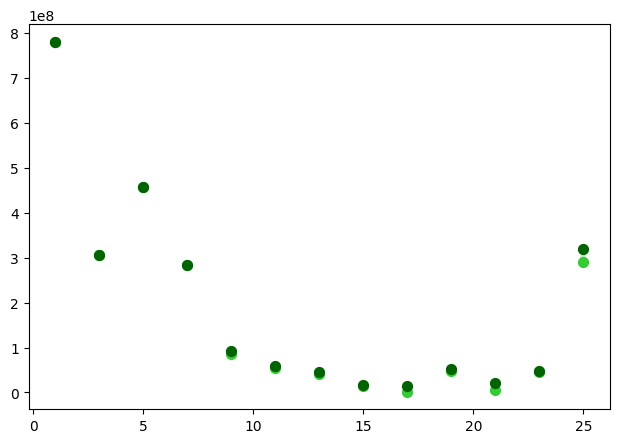

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=(7.5,5), sharex=True)

my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range2=np.arange(2,(len(Results_PlotSummary.index))*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
          ymax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)
ax.scatter(my_range1, Results_PlotSummary['Minimum recovery cost (EUR/year)'], s=size,
           color='limegreen', alpha=1, label='Min cost', zorder=2)
ax.scatter(my_range1, Results_PlotSummary['Maximum recovery cost (EUR/year)'], s=size,
           color='darkgreen', alpha=1 , label='Max cost', zorder=2)

# ax2.scatter(my_range1, Results_PlotSummary['Minimum recovery cost (EUR/year)'], s=size,
#             color='limegreen', alpha=1, label='Min cost', zorder=2)
# ax2.scatter(my_range1, Results_PlotSummary['Maximum recovery cost (EUR/year)'], s=size,
#             color='darkgreen', alpha=1 , label='Max cost', zorder=2)
# ax2.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
#           ymax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# # zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# ax2.xaxis.tick_bottom()

# # This looks pretty good, and was fairly painless, but you can get that
# # cut-out diagonal lines look with just a bit more work. The important
# # thing to know here is that in axes coordinates, which are always
# # between 0-1, spine endpoints are at these locations (0,0), (0,1),
# # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# # appropriate corners of each of our axes, and so long as we use the
# # right transform and disable clipping.

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# # What's cool about this is that now if we vary the distance between
# # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # the diagonal lines will move accordingly, and stay right at the tips
# # of the spines they are 'breaking'
# ax.set_ylim(ylim)
# ax2.set_ylim(ylim2)
# fig.subplots_adjust(hspace=0.15)



# ax.spines['left'].set_color('darkgreen')
# ax2.spines['left'].set_color('darkgreen')

# # ax.yaxis.label.set_color('darkgreen')
# # ax2.yaxis.label.set_color('darkgreen')

# ax.tick_params(axis='y', colors='darkgreen')
# ax2.tick_params(axis='y', colors='darkgreen')

# ax2.legend()

# plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummary.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

In [9]:
# fig = plt.figure(figsize=(7.5,5))

# my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
# my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# bax = brokenaxes(ylims=((0, 1E8), (2.5E8, 1E9)), hspace=.15, height_ratios=[1,2])

# bax.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
#           ymax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)
# bax.scatter(my_range1, Results_PlotSummary['Minimum recovery cost (EUR/year)'], s=size,
#            color='limegreen', alpha=1, label='Min cost', zorder=2)
# bax.scatter(my_range1, Results_PlotSummary['Maximum recovery cost (EUR/year)'], s=size,
#            color='darkgreen', alpha=1 , label='Max cost', zorder=2)


# # Then, we get the different axes created and set the ticks according to the
# # axe x and y limits.

# for i, ax in enumerate(bax.last_row):
#     ax.xaxis.set_major_locator(ticker.AutoLocator())
#     # ax.set_xlabel('xscale {i}'.format(i=i))
# for i, ax in enumerate(bax.first_col):
#     ax.yaxis.set_major_locator(ticker.AutoLocator())
#     # ax.set_ylabel('yscale {i}'.format(i=i))

    
# # Secondary axis 
# # You can customize brokenaxes outside of the supported features listed above. Brokenaxes works by creating a number of smaller axes objects, with the positions and sizes of those axes dictated by the data ranges used in the constructor. Those individual axes are stored as a list in bax.axs. Most customizations will require accessing those inner axes objects. (See the last two lines of the datetime example). There is also a larger invisible axes object, bax.big_ax, which spans the entire brokenaxes region and is used for things like x and y axis labels which span all of the smaller axes.
# # https://github.com/bendichter/brokenaxes
# ax3 = bax.axs[0].twinx()
# ax4 = bax.axs[1].twinx()
# # ax3 = bax.big_ax.twinx()
# ax3.spines['left'].set_visible(False)

# ax3.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
#           ymax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='cornflowerblue', alpha=0.3, linewidths=4, zorder=1)
# ax3.scatter(my_range1, Results_PlotSummary['Minimum P recovered (kg P/year)'], s=size, marker='*',
#            color='cornflowerblue', alpha=0.5, label='Min cost', zorder=2)
# ax3.scatter(my_range1, Results_PlotSummary['Maximum P recovered (kg P/year)'], s=size, marker='*',
#            color='navy', alpha=0.5 , label='Max cost', zorder=2)

# ax4.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
#           ymax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='cornflowerblue', alpha=0.3, linewidths=4, zorder=1)
# ax4.scatter(my_range1, Results_PlotSummary['Minimum P recovered (kg P/year)'], s=size, marker='*',
#            color='cornflowerblue', alpha=0.5, label='Min cost', zorder=2)
# ax4.scatter(my_range1, Results_PlotSummary['Maximum P recovered (kg P/year)'], s=size, marker='*',
#            color='navy', alpha=0.5 , label='Max cost', zorder=2)


# # # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # # hide the spines between ax and ax2
# # ax.spines['bottom'].set_visible(False)
# # ax2.spines['top'].set_visible(False)
# # # ax.xaxis.tick_top()
# # # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# # ax.tick_params(
# #     axis='x',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom=False,      # ticks along the bottom edge are off
# #     top=False,         # ticks along the top edge are off
# #     labelbottom=False) # labels along the bottom edge are off
# # ax2.xaxis.tick_bottom()

# # # This looks pretty good, and was fairly painless, but you can get that
# # # cut-out diagonal lines look with just a bit more work. The important
# # # thing to know here is that in axes coordinates, which are always
# # # between 0-1, spine endpoints are at these locations (0,0), (0,1),
# # # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# # # appropriate corners of each of our axes, and so long as we use the
# # # right transform and disable clipping.

# # d = .015  # how big to make the diagonal lines in axes coordinates
# # # arguments to pass to plot, just so we don't keep repeating them
# # kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# # ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# # ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# # kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# # ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# # ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# # # What's cool about this is that now if we vary the distance between
# # # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # # the diagonal lines will move accordingly, and stay right at the tips
# # # of the spines they are 'breaking'
# # ax.set_ylim(ylim)
# # ax2.set_ylim(ylim2)
# # fig.subplots_adjust(hspace=0.15)

# # bax.legend()

# plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummary.pdf', bbox_inches='tight',)

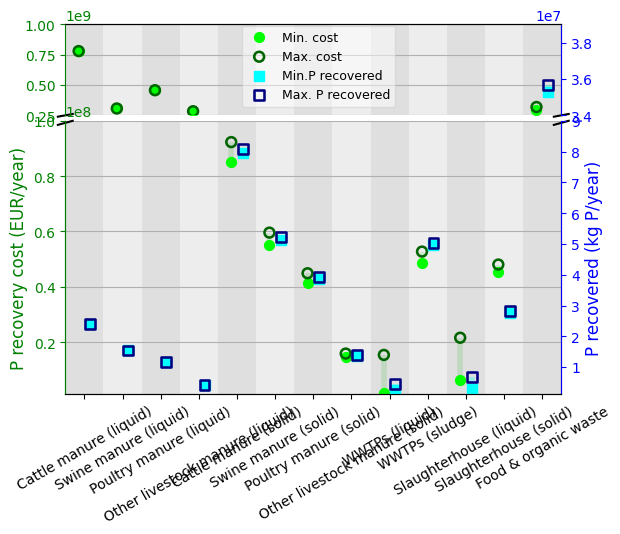

In [10]:
###### fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)

ylim  = [2.5E8, 1E9]
ylim2 = [1.3E6, 1E8]
# ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
fig = plt.figure()
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

padding = 0.6
my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range11=[i+padding for i in my_range1]
my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
          ymax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)
ax.scatter(my_range1, Results_PlotSummary['Minimum recovery cost (EUR/year)'], s=size,
           color='lime', alpha=1, label='Min. cost', zorder=2)
ax.scatter(my_range1, Results_PlotSummary['Maximum recovery cost (EUR/year)'], s=size,
           facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. cost', zorder=2)

ax2.scatter(my_range1, Results_PlotSummary['Minimum recovery cost (EUR/year)'], s=size,
            color='lime', alpha=1, zorder=2) #label='Min cost',
ax2.scatter(my_range1, Results_PlotSummary['Maximum recovery cost (EUR/year)'], s=size,
            facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
            alpha=1, zorder=2) #label='Max cost'
ax2.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
          ymax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 ), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 ), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax.set_ylim(ylim)
ax2.set_ylim(ylim2)
fig.subplots_adjust(hspace=0.03)



ax.spines['left'].set_color('green')
ax2.spines['left'].set_color('green')

ax.yaxis.label.set_color('green')
ax2.yaxis.label.set_color('green')

ax.tick_params(axis='y', colors='green')
ax2.tick_params(axis='y', colors='green')

# ax2.legend()

ylim3 = [3.4E7, 3.9E7]
ylim4 = [1.3E5, 9E6]


ax3 = ax.twinx()
ax4 = ax2.twinx()
# ax3 = bax.big_ax.twinx()
ax3.spines['left'].set_visible(False)

ax3.vlines(x=my_range11, ymin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
          ymax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)
ax3.scatter(my_range11, Results_PlotSummary['Minimum P recovered (kg P/year)'], s=size, marker='s',
           color='aqua', alpha=1, label='Min.P recovered', zorder=2)
ax3.scatter(my_range11, Results_PlotSummary['Maximum P recovered (kg P/year)'], s=size,
           facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. P recovered', zorder=2)

ax4.scatter(my_range11, Results_PlotSummary['Minimum P recovered (kg P/year)'], s=size,
            color='aqua', marker='s', alpha=1, zorder=2) #label='Min cost',
ax4.scatter(my_range11, Results_PlotSummary['Maximum P recovered (kg P/year)'], s=size,
            facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
            alpha=1, zorder=2) #label='Max cost'
ax4.vlines(x=my_range11, ymin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
          ymax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)


        


# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax3.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax3.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax4.xaxis.tick_bottom()

ax3.set_ylim(ylim3)
ax4.set_ylim(ylim4)

ax3.spines['left'].set_color('green')
ax4.spines['left'].set_color('green')

ax3.spines['right'].set_color('blue')
ax4.spines['right'].set_color('blue')

ax3.yaxis.label.set_color('blue')
ax4.yaxis.label.set_color('blue')

ax3.tick_params(axis='y', colors='blue')
ax4.tick_params(axis='y', colors='blue')

ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1s'))


# legends
# lns = lns10+lns11+lns20+lns21
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)
fig.legend(bbox_to_anchor=(0.65,0.89), prop={'size':9}, framealpha=0.5)

# Create names on the x-axis
plt.xticks([i + padding/2 for i in my_range1], Results_PlotSummary.index.to_list())
ax2.xaxis.set_tick_params(rotation=30)

ax2.set_ylabel("P recovery cost (EUR/year)", fontsize=12)
ax4.set_ylabel("P recovered (kg P/year)", fontsize=12)


# We set the xlim to fit the shade
ax.set_xlim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])
ax2.set_xlim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])

ax.grid(axis='y')
ax2.grid(axis='y')


# Shaded backgournd
separation = (3-(1+padding))/2
counter = 0
for i in my_range1:
    if counter == 0:
        ax2.axvspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5)
        ax.axvspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5)
        counter = 1
        
    elif counter == 1:
        ax2.axvspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5)
        ax.axvspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5)
        counter = 0


# plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummary.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

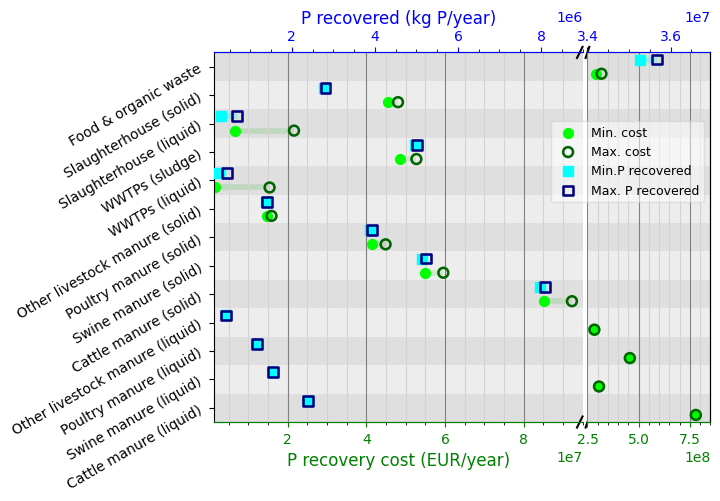

In [11]:
###### fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)

xlim  = [2.5E8, 8.5E8]
xlim2 = [1.3E6, 0.95E8]
# ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
gs.update(wspace=0.02)
fig = plt.figure()
ax2 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

padding = 1
my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range11=[i+padding for i in my_range1]
my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax2.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
          xmax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)
ax2.scatter(Results_PlotSummary['Minimum recovery cost (EUR/year)'], my_range1, s=size,
           color='lime', alpha=1, label='Min. cost', zorder=2)
ax2.scatter(Results_PlotSummary['Maximum recovery cost (EUR/year)'], my_range1, s=size,
           facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. cost', zorder=2)

ax.scatter(Results_PlotSummary['Minimum recovery cost (EUR/year)'], my_range1, s=size,
            color='lime', alpha=1, zorder=2) #label='Min cost',
ax.scatter(Results_PlotSummary['Maximum recovery cost (EUR/year)'], my_range1, s=size,
            facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
            alpha=1, zorder=2) #label='Max cost'
ax.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
          xmax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax2.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelright=False) # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
# ax.xaxis.tick_bottom()

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), zorder=2, **kwargs)        # top-left diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), zorder=2, **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax.plot((1 - d, 1 ), (-d, +d), zorder=2, **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 ), (1 - d, 1 + d), zorder=2, **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax2.set_xlim(xlim2)
ax.set_xlim(xlim)
fig.subplots_adjust(hspace=0.03)



ax.spines['bottom'].set_color('green')
ax2.spines['bottom'].set_color('green')

ax.xaxis.label.set_color('green')
ax2.xaxis.label.set_color('green')

ax.tick_params(axis='x', colors='green')
ax2.tick_params(axis='x', colors='green')

# ax2.legend()

xlim3 = [3.4E7, 3.6955E7]
xlim4 = [1.3E5, 9E6]


ax3 = ax.twiny()
ax4 = ax2.twiny()
# ax3 = bax.big_ax.twinx()
ax4.spines['left'].set_visible(False)

ax4.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
          xmax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)
ax4.scatter(Results_PlotSummary['Minimum P recovered (kg P/year)'], my_range11, s=size, marker='s',
           color='aqua', alpha=1, label='Min.P recovered', zorder=2)
ax4.scatter(Results_PlotSummary['Maximum P recovered (kg P/year)'], my_range11, s=size,
           facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. P recovered', zorder=2)

ax3.scatter(Results_PlotSummary['Minimum P recovered (kg P/year)'], my_range11, s=size,
            color='aqua', marker='s', alpha=1, zorder=2) #label='Min cost',
ax3.scatter(Results_PlotSummary['Maximum P recovered (kg P/year)'], my_range11, s=size,
            facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
            alpha=1, zorder=2) #label='Max cost'
ax3.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
          xmax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)


        


# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax4.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax4.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelright=False) # labels along the bottom edge are off

ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax3.set_xlim(xlim3)
ax4.set_xlim(xlim4)

ax3.spines['bottom'].set_color('green')
ax4.spines['bottom'].set_color('green')

ax3.spines['top'].set_color('blue')
ax4.spines['top'].set_color('blue')

ax3.xaxis.label.set_color('blue')
ax4.xaxis.label.set_color('blue')

ax3.tick_params(axis='x', colors='blue')
ax4.tick_params(axis='x', colors='blue')

# ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1s'))


# legends
# lns = lns10+lns11+lns20+lns21
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)
fig.legend(bbox_to_anchor=(0.9,0.75), prop={'size':9}, framealpha=0.5)

# Create names on the x-axis
# plt.yticks([i + padding/2 for i in my_range1], Results_PlotSummary.index.to_list())
ax2.set_yticks([i + padding/2 for i in my_range1])
# ax1.set_xticklabels(squad, minor=False, rotation=45)
ax2.set_yticklabels(Results_PlotSummary.index.to_list())
ax2.yaxis.set_tick_params(rotation=30)

ax2.set_xlabel("P recovery cost (EUR/year)", fontsize=12)
ax4.set_xlabel("P recovered (kg P/year)", fontsize=12)


# We set the xlim to fit the shade
ax.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])
ax2.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])

# ax.grid(axis='x')
# ax2.grid(axis='x')

ax.grid(axis='x',which='major', color='grey', linestyle='-')
ax.grid(axis='x',which='minor', color='lightgrey', linestyle='-')
ax2.grid(axis='x',which='major', color='grey', linestyle='-')
ax2.grid(axis='x',which='minor', color='lightgrey', linestyle='-')


# Shaded backgournd
separation = (3-(1+padding))/2
counter = 0
for i in my_range1:
    if counter == 0:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        counter = 1
        
    elif counter == 1:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        counter = 0


plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummary.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

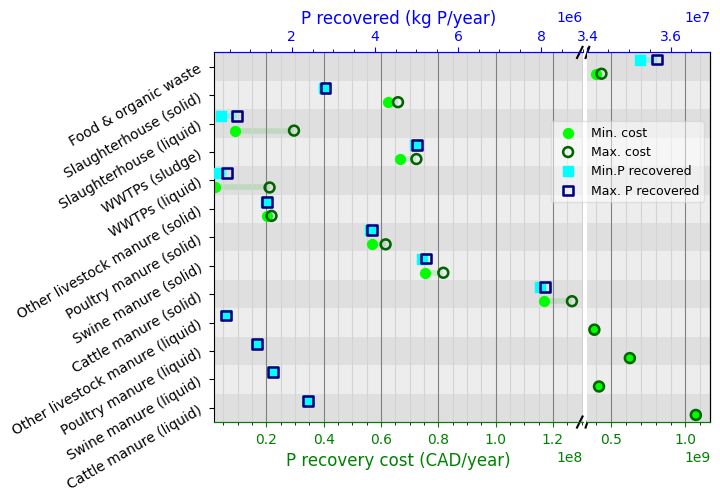

In [22]:
###### fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
EURtoCAD = 1.372 #https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-cad.en.html

xlim  = [2.5E8*EURtoCAD, 8.5E8*EURtoCAD]
xlim2 = [1.3E6*EURtoCAD, 0.95E8*EURtoCAD]
# ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
gs.update(wspace=0.02)
fig = plt.figure()
ax2 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

padding = 1
my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range11=[i+padding for i in my_range1]
my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax2.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum recovery cost (EUR/year)']*EURtoCAD,
          xmax=Results_PlotSummary['Maximum recovery cost (EUR/year)']*EURtoCAD, color='limegreen', alpha=0.3, linewidths=4, zorder=1)
ax2.scatter(Results_PlotSummary['Minimum recovery cost (EUR/year)']*EURtoCAD, my_range1, s=size,
           color='lime', alpha=1, label='Min. cost', zorder=2)
ax2.scatter(Results_PlotSummary['Maximum recovery cost (EUR/year)']*EURtoCAD, my_range1, s=size,
           facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. cost', zorder=2)

ax.scatter(Results_PlotSummary['Minimum recovery cost (EUR/year)']*EURtoCAD, my_range1, s=size,
            color='lime', alpha=1, zorder=2) #label='Min cost',
ax.scatter(Results_PlotSummary['Maximum recovery cost (EUR/year)']*EURtoCAD, my_range1, s=size,
            facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
            alpha=1, zorder=2) #label='Max cost'
ax.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum recovery cost (EUR/year)']*EURtoCAD,
          xmax=Results_PlotSummary['Maximum recovery cost (EUR/year)']*EURtoCAD, color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax2.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelright=False) # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
# ax.xaxis.tick_bottom()

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), zorder=2, **kwargs)        # top-left diagonal
ax2.plot((-d, +d), (1 - d, 1 + d), zorder=2, **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax.plot((1 - d, 1 ), (-d, +d), zorder=2, **kwargs)  # bottom-left diagonal
ax.plot((1 - d, 1 ), (1 - d, 1 + d), zorder=2, **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax2.set_xlim(xlim2)
ax.set_xlim(xlim)
fig.subplots_adjust(hspace=0.03)



ax.spines['bottom'].set_color('green')
ax2.spines['bottom'].set_color('green')

ax.xaxis.label.set_color('green')
ax2.xaxis.label.set_color('green')

ax.tick_params(axis='x', colors='green')
ax2.tick_params(axis='x', colors='green')

# ax2.legend()

xlim3 = [3.4E7, 3.6955E7]
xlim4 = [1.3E5, 9E6]


ax3 = ax.twiny()
ax4 = ax2.twiny()
# ax3 = bax.big_ax.twinx()
ax4.spines['left'].set_visible(False)

ax4.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
          xmax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)
ax4.scatter(Results_PlotSummary['Minimum P recovered (kg P/year)'], my_range11, s=size, marker='s',
           color='aqua', alpha=1, label='Min.P recovered', zorder=2)
ax4.scatter(Results_PlotSummary['Maximum P recovered (kg P/year)'], my_range11, s=size,
           facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. P recovered', zorder=2)

ax3.scatter(Results_PlotSummary['Minimum P recovered (kg P/year)'], my_range11, s=size,
            color='aqua', marker='s', alpha=1, zorder=2) #label='Min cost',
ax3.scatter(Results_PlotSummary['Maximum P recovered (kg P/year)'], my_range11, s=size,
            facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
            alpha=1, zorder=2) #label='Max cost'
ax3.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
          xmax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)


        


# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax4.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax4.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelright=False) # labels along the bottom edge are off

ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax3.set_xlim(xlim3)
ax4.set_xlim(xlim4)

ax3.spines['bottom'].set_color('green')
ax4.spines['bottom'].set_color('green')

ax3.spines['top'].set_color('blue')
ax4.spines['top'].set_color('blue')

ax3.xaxis.label.set_color('blue')
ax4.xaxis.label.set_color('blue')

ax3.tick_params(axis='x', colors='blue')
ax4.tick_params(axis='x', colors='blue')

# ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1s'))


# legends
# lns = lns10+lns11+lns20+lns21
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)
fig.legend(bbox_to_anchor=(0.9,0.75), prop={'size':9}, framealpha=0.5)

# Create names on the x-axis
# plt.yticks([i + padding/2 for i in my_range1], Results_PlotSummary.index.to_list())
ax2.set_yticks([i + padding/2 for i in my_range1])
# ax1.set_xticklabels(squad, minor=False, rotation=45)
ax2.set_yticklabels(Results_PlotSummary.index.to_list())
ax2.yaxis.set_tick_params(rotation=30)

ax2.set_xlabel("P recovery cost (CAD/year)", fontsize=12)
ax4.set_xlabel("P recovered (kg P/year)", fontsize=12)


# We set the xlim to fit the shade
ax.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])
ax2.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])

# ax.grid(axis='x')
# ax2.grid(axis='x')

ax.grid(axis='x',which='major', color='grey', linestyle='-')
ax.grid(axis='x',which='minor', color='lightgrey', linestyle='-')
ax2.grid(axis='x',which='major', color='grey', linestyle='-')
ax2.grid(axis='x',which='minor', color='lightgrey', linestyle='-')


# Shaded backgournd
separation = (3-(1+padding))/2
counter = 0
for i in my_range1:
    if counter == 0:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        counter = 1
        
    elif counter == 1:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        counter = 0


plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummaryCAD.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

In [12]:
Results_PlotSummary.index.to_list()

['Cattle manure (liquid)',
 'Swine manure (liquid)',
 'Poultry manure (liquid)',
 'Other livestock manure (liquid)',
 'Cattle manure (solid)',
 'Swine manure (solid)',
 'Poultry manure (solid)',
 'Other livestock manure (solid)',
 'WWTPs (liquid)',
 'WWTPs (sludge)',
 'Slaughterhouse (liquid)',
 'Slaughterhouse (solid)',
 'Food & organic waste']

### Plot of relative values

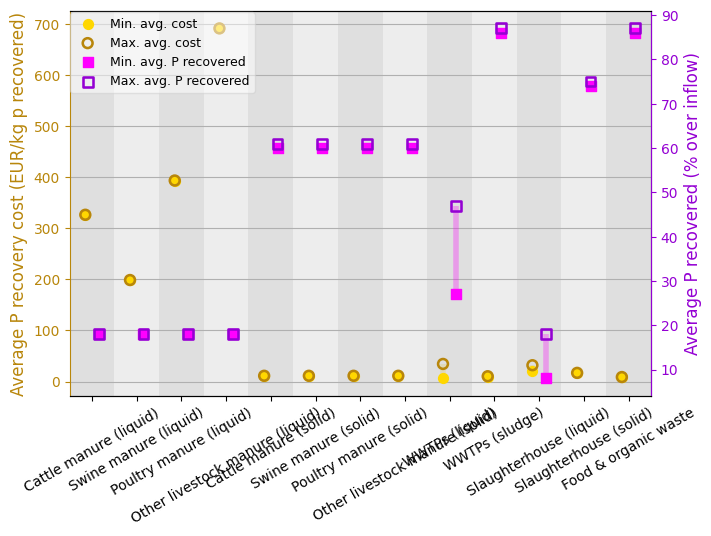

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7.5,5), sharex=True)

# ylim  = [2.5E8, 1E9]
# ylim2 = [1.3E6, 1E8]
# # ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# # ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
# fig = plt.figure()
# ax = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])

padding = 0.6
my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range11=[i+padding for i in my_range1]
my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum P recovery cost (EUR/kg P recovered)'],
          ymax=Results_PlotSummary['Maximum P recovery cost (EUR/kg P recovered)'], color='gold', alpha=0.3, linewidths=4, zorder=1)
ax.scatter(my_range1, Results_PlotSummary['Minimum P recovery cost (EUR/kg P recovered)'], s=size,
           color='gold', alpha=1, label='Min. avg. cost', zorder=2)
ax.scatter(my_range1, Results_PlotSummary['Maximum P recovery cost (EUR/kg P recovered)'], s=size,
           facecolors='none', edgecolors='darkgoldenrod', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. avg. cost', zorder=2)

# ax2.scatter(my_range1, Results_PlotSummary['Minimum recovery cost (EUR/year)'], s=size,
#             color='lime', alpha=1, zorder=2) #label='Min cost',
# ax2.scatter(my_range1, Results_PlotSummary['Maximum recovery cost (EUR/year)'], s=size,
#             facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
#             alpha=1, zorder=2) #label='Max cost'
# ax2.vlines(x=my_range1, ymin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
#           ymax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# ax2.xaxis.tick_bottom()

# # This looks pretty good, and was fairly painless, but you can get that
# # cut-out diagonal lines look with just a bit more work. The important
# # thing to know here is that in axes coordinates, which are always
# # between 0-1, spine endpoints are at these locations (0,0), (0,1),
# # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# # appropriate corners of each of our axes, and so long as we use the
# # right transform and disable clipping.

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 ), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 ), **kwargs)  # bottom-right diagonal

# # What's cool about this is that now if we vary the distance between
# # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # the diagonal lines will move accordingly, and stay right at the tips
# # of the spines they are 'breaking'
# ax.set_ylim(ylim)
# ax2.set_ylim(ylim2)
# fig.subplots_adjust(hspace=0.03)



ax.spines['left'].set_color('darkgoldenrod')
# ax2.spines['left'].set_color('green')

ax.yaxis.label.set_color('darkgoldenrod')
# ax2.yaxis.label.set_color('green')

ax.tick_params(axis='y', colors='darkgoldenrod')
# ax2.tick_params(axis='y', colors='green')

## ax2.legend()

# ylim3 = [3.4E7, 3.9E7]
# ylim4 = [1.3E5, 9E6]


ax3 = ax.twinx()
# ax4 = ax2.twinx()
# # ax3 = bax.big_ax.twinx()
ax3.spines['left'].set_visible(False)

ax3.vlines(x=my_range11, ymin=Results_PlotSummary['Minimum P recovered (% over inflow)'],
          ymax=Results_PlotSummary['Maximum P recovered (% over inflow)'], color='magenta', alpha=0.3, linewidths=4, zorder=1)
ax3.scatter(my_range11, Results_PlotSummary['Minimum P recovered (% over inflow)'], s=size, marker='s',
           color='magenta',
            alpha=1, label='Min. avg. P recovered', zorder=2)
ax3.scatter(my_range11, Results_PlotSummary['Maximum P recovered (% over inflow)'], s=size, marker='s',
           facecolors='none', edgecolors='darkviolet', linewidths=1.85, #color='navy', 
            alpha=1 , label='Max. avg. P recovered', zorder=2)

# ax4.vlines(x=my_range11, ymin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
#           ymax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='cornflowerblue', alpha=0.3, linewidths=4, zorder=1)
# ax4.scatter(my_range11, Results_PlotSummary['Minimum P recovered (kg P/year)'], s=size, marker='s',
#            color='aqua', alpha=1, zorder=2) #label='Min P recovered',
# ax4.scatter(my_range11, Results_PlotSummary['Maximum P recovered (kg P/year)'], s=size, marker='s',
#            facecolors='none', edgecolors='navy', linewidths=1.85, #color='navy', 
#             alpha=1, zorder=2) #label='Max P recovered',


# # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax3.spines['bottom'].set_visible(False)
# ax4.spines['top'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax3.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# ax4.xaxis.tick_bottom()

# ax3.set_ylim(ylim3)
# ax4.set_ylim(ylim4)

# ax3.spines['left'].set_color('green')
# ax4.spines['left'].set_color('green')

ax3.spines['right'].set_color('darkviolet')
# ax4.spines['right'].set_color('blue')

ax3.yaxis.label.set_color('darkviolet')
# ax4.yaxis.label.set_color('blue')

ax3.tick_params(axis='y', colors='darkviolet')
# ax4.tick_params(axis='y', colors='blue')

## legends
## lns = lns10+lns11+lns20+lns21
## labs = [l.get_label() for l in lns]
## ax.legend(lns, labs, loc=0)
fig.legend(bbox_to_anchor=(0.38,0.89), prop={'size':9}, framealpha=0.5)

# Create names on the x-axis
plt.xticks([i + padding/2 for i in my_range1], Results_PlotSummary.index.to_list())
ax.xaxis.set_tick_params(rotation=30)

ax.set_ylabel("Average P recovery cost (EUR/kg p recovered)", fontsize=12)
ax3.set_ylabel("Average P recovered (% over inflow)", fontsize=12)


# We set the xlim to fit the shade
ax.set_xlim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])
# ax2.set_xlim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])

ax.grid(axis='y')
ax2.grid(axis='y')


# Shaded backgournd
separation = (3-(1+padding))/2
counter = 0
for i in my_range1:
    if counter == 0:
        # ax2.axvspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5)
        ax.axvspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5)
        counter = 1
        
    elif counter == 1:
        # ax2.axvspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5)
        ax.axvspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5)
        counter = 0


# plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummarySpecific.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

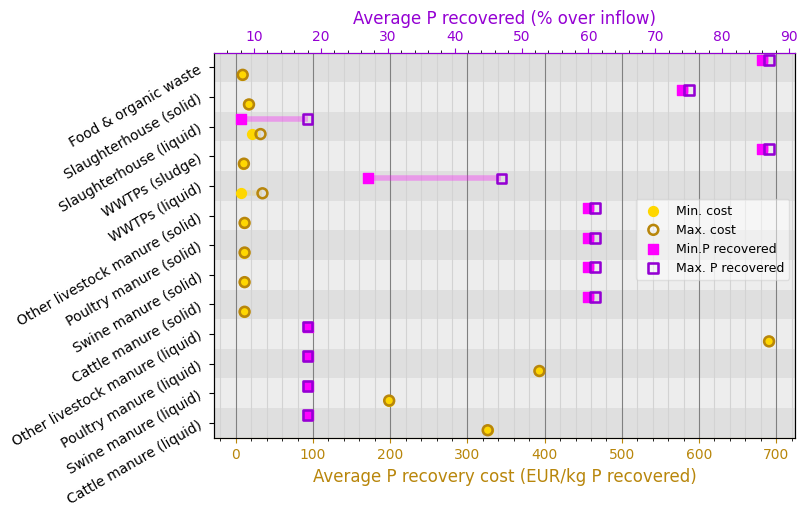

In [16]:
fig, ax2 = plt.subplots(1, 1, figsize=(7.5,5), sharex=True)

# ###### fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)

# # xlim  = [2.5E8, 1E9]
# # xlim2 = [1.3E6, 1E8]
# # ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# # ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
# gs.update(wspace=0.02)
# fig = plt.figure()
# ax2 = fig.add_subplot(gs[0])
# ax = fig.add_subplot(gs[1])

padding = 1
my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range11=[i+padding for i in my_range1]
my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax2.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum P recovery cost (EUR/kg P recovered)'],
          xmax=Results_PlotSummary['Maximum P recovery cost (EUR/kg P recovered)'], color='gold', alpha=0.3, linewidths=4, zorder=1)
ax2.scatter(Results_PlotSummary['Minimum P recovery cost (EUR/kg P recovered)'], my_range1, s=size,
           color='gold', alpha=1, label='Min. cost', zorder=2)
ax2.scatter(Results_PlotSummary['Maximum P recovery cost (EUR/kg P recovered)'], my_range1, s=size,
           facecolors='none', edgecolors='darkgoldenrod', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. cost', zorder=2)

# ax.scatter(Results_PlotSummary['Minimum recovery cost (EUR/year)'], my_range1, s=size,
#             color='lime', alpha=1, zorder=2) #label='Min cost',
# ax.scatter(Results_PlotSummary['Maximum recovery cost (EUR/year)'], my_range1, s=size,
#             facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
#             alpha=1, zorder=2) #label='Max cost'
# ax.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
#           xmax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax4.spines['right'].set_visible(False)
# ax3.spines['left'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax4.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     right=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelright=False) # labels along the bottom edge are off

# ax3.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelleft=False) # labels along the bottom edge are off

# ax3.set_xlim(xlim3)
# ax4.set_xlim(xlim4)only
# ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax2.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax2.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     right=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelright=False) # labels along the bottom edge are off

# ax.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelleft=False) # labels along the bottom edge are off
# # ax.xaxis.tick_bottom()

# # This looks pretty good, and was fairly painless, but you can get that
# # cut-out diagonal lines look with just a bit more work. The important
# # thing to know here is that in axes coordinates, which are always
# # between 0-1, spine endpoints are at these locations (0,0), (0,1),
# # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# # appropriate corners of each of our axes, and so long as we use the
# # right transform and disable clipping.

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax2.plot((-d, +d), (-d, +d), zorder=2, **kwargs)        # top-left diagonal
# ax2.plot((-d, +d), (1 - d, 1 + d), zorder=2, **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax.plot((1 - d, 1 ), (-d, +d), zorder=2, **kwargs)  # bottom-left diagonal
# ax.plot((1 - d, 1 ), (1 - d, 1 + d), zorder=2, **kwargs)  # bottom-right diagonal

# # What's cool about this is that now if we vary the distance between
# # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # the diagonal lines will move accordingly, and stay right at the tips
# # of the spines they are 'breaking'
# ax2.set_xlim(xlim2)
# ax.set_xlim(xlim)
# fig.subplots_adjust(hspace=0.03)

ax2.xaxis.set_minor_locator(AutoMinorLocator())

# ax.spines['bottom'].set_color('green')
ax2.spines['bottom'].set_color('darkgoldenrod')

# ax.xaxis.label.set_color('green')
ax2.xaxis.label.set_color('darkgoldenrod')

# ax.tick_params(axis='x', colors='green')
ax2.tick_params(axis='x', colors='darkgoldenrod')

# ax2.legend()

xlim3 = [3.4E7, 3.9E7]
xlim4 = [1.3E5, 9E6]


# ax3 = ax.twiny()
ax4 = ax2.twiny()
# ax3 = bax.big_ax.twinx()
# ax4.spines['left'].set_visible(False)

ax4.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (% over inflow)'],
          xmax=Results_PlotSummary['Maximum P recovered (% over inflow)'], color='magenta', alpha=0.3, linewidths=4, zorder=1)
ax4.scatter(Results_PlotSummary['Minimum P recovered (% over inflow)'], my_range11, s=size, marker='s',
           color='magenta', alpha=1, label='Min.P recovered', zorder=2)
ax4.scatter(Results_PlotSummary['Maximum P recovered (% over inflow)'], my_range11, s=size,
           facecolors='none', edgecolors='darkviolet', marker='s', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. P recovered', zorder=2)

# ax3.scatter(Results_PlotSummary['Minimum P recovered (kg P/year)'], my_range11, s=size,
#             color='aqua', marker='s', alpha=1, zorder=2) #label='Min cost',
# ax3.scatter(Results_PlotSummary['Maximum P recovered (kg P/year)'], my_range11, s=size,
#             facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
#             alpha=1, zorder=2) #label='Max cost'
# ax3.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
#           xmax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)


        


# # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax4.spines['right'].set_visible(False)
# ax3.spines['left'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax4.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     right=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelright=False) # labels along the bottom edge are off

# ax3.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelleft=False) # labels along the bottom edge are off

# ax3.set_xlim(xlim3)
# ax4.set_xlim(xlim4)

# ax3.spines['bottom'].set_color('green')
# ax4.spines['bottom'].set_color('green')

ax4.xaxis.set_minor_locator(AutoMinorLocator())

# ax3.spines['top'].set_color('blue')
ax4.spines['top'].set_color('darkviolet')

# ax3.xaxis.label.set_color('blue')
ax4.xaxis.label.set_color('darkviolet')

# ax3.tick_params(axis='x', colors='blue')
ax4.tick_params(axis='x', colors='darkviolet')

# ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1s'))


# legends
# lns = lns10+lns11+lns20+lns21
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)
fig.legend(bbox_to_anchor=(0.9,0.6), prop={'size':9}, framealpha=0.5)

# Create names on the x-axis
# plt.yticks([i + padding/2 for i in my_range1], Results_PlotSummary.index.to_list())
ax2.set_yticks([i + padding/2 for i in my_range1])
# ax1.set_xticklabels(squad, minor=False, rotation=45)
ax2.set_yticklabels(Results_PlotSummary.index.to_list())
ax2.yaxis.set_tick_params(rotation=30)

ax2.set_xlabel("Average P recovery cost (EUR/kg P recovered)", fontsize=12)
ax4.set_xlabel("Average P recovered (% over inflow)", fontsize=12)


# We set the xlim to fit the shade
# ax.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])
ax2.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])

# ax.grid(axis='x')
ax2.grid(axis='x',which='major', color='grey', linestyle='-')
ax2.grid(axis='x',which='minor', color='lightgrey', linestyle='-')


# Shaded backgournd
separation = (3-(1+padding))/2
counter = 0
for i in my_range1:
    if counter == 0:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        counter = 1
        
    elif counter == 1:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        counter = 0


plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummarySpecific.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

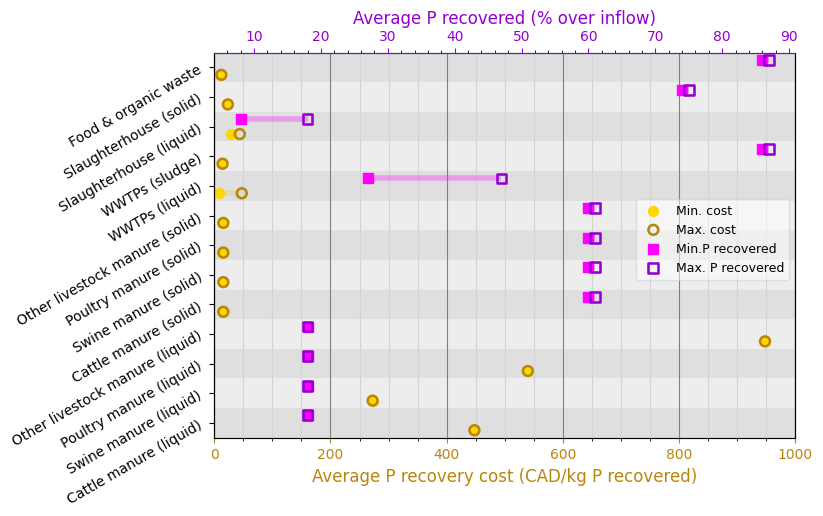

In [21]:
fig, ax2 = plt.subplots(1, 1, figsize=(7.5,5), sharex=True)

EURtoCAD = 1.372 #https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-cad.en.html

# ###### fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)

# # xlim  = [2.5E8, 1E9]
# # xlim2 = [1.3E6, 1E8]
# # ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# # ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
# gs.update(wspace=0.02)
# fig = plt.figure()
# ax2 = fig.add_subplot(gs[0])
# ax = fig.add_subplot(gs[1])

padding = 1
my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
my_range11=[i+padding for i in my_range1]
my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
size = 50

# ax3 = ax.twinx()
# ax4 = ax2.twinx()

ax2.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum P recovery cost (EUR/kg P recovered)']*EURtoCAD,
          xmax=Results_PlotSummary['Maximum P recovery cost (EUR/kg P recovered)']*EURtoCAD, color='gold', alpha=0.3, linewidths=4, zorder=1)
ax2.scatter(Results_PlotSummary['Minimum P recovery cost (EUR/kg P recovered)']*EURtoCAD, my_range1, s=size,
           color='gold', alpha=1, label='Min. cost', zorder=2)
ax2.scatter(Results_PlotSummary['Maximum P recovery cost (EUR/kg P recovered)']*EURtoCAD, my_range1, s=size,
           facecolors='none', edgecolors='darkgoldenrod', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. cost', zorder=2)

# ax.scatter(Results_PlotSummary['Minimum recovery cost (EUR/year)'], my_range1, s=size,
#             color='lime', alpha=1, zorder=2) #label='Min cost',
# ax.scatter(Results_PlotSummary['Maximum recovery cost (EUR/year)'], my_range1, s=size,
#             facecolors='none', edgecolors='darkgreen', linewidths=1.85, #color='darkgreen', 
#             alpha=1, zorder=2) #label='Max cost'
# ax.hlines(y=my_range1, xmin=Results_PlotSummary['Minimum recovery cost (EUR/year)'],
#           xmax=Results_PlotSummary['Maximum recovery cost (EUR/year)'], color='limegreen', alpha=0.3, linewidths=4, zorder=1)

# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax4.spines['right'].set_visible(False)
# ax3.spines['left'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax4.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     right=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelright=False) # labels along the bottom edge are off

# ax3.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelleft=False) # labels along the bottom edge are off

# ax3.set_xlim(xlim3)
# ax4.set_xlim(xlim4)only
ax2.set_xlim(0, 1000)  # most of the data

# # hide the spines between ax and ax2
# ax2.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax2.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     right=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelright=False) # labels along the bottom edge are off

# ax.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelleft=False) # labels along the bottom edge are off
# # ax.xaxis.tick_bottom()

# # This looks pretty good, and was fairly painless, but you can get that
# # cut-out diagonal lines look with just a bit more work. The important
# # thing to know here is that in axes coordinates, which are always
# # between 0-1, spine endpoints are at these locations (0,0), (0,1),
# # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# # appropriate corners of each of our axes, and so long as we use the
# # right transform and disable clipping.

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax2.plot((-d, +d), (-d, +d), zorder=2, **kwargs)        # top-left diagonal
# ax2.plot((-d, +d), (1 - d, 1 + d), zorder=2, **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax.plot((1 - d, 1 ), (-d, +d), zorder=2, **kwargs)  # bottom-left diagonal
# ax.plot((1 - d, 1 ), (1 - d, 1 + d), zorder=2, **kwargs)  # bottom-right diagonal

# # What's cool about this is that now if we vary the distance between
# # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # the diagonal lines will move accordingly, and stay right at the tips
# # of the spines they are 'breaking'
# ax2.set_xlim(xlim2)
# ax.set_xlim(xlim)
# fig.subplots_adjust(hspace=0.03)

ax2.xaxis.set_minor_locator(AutoMinorLocator())

# ax.spines['bottom'].set_color('green')
ax2.spines['bottom'].set_color('darkgoldenrod')

# ax.xaxis.label.set_color('green')
ax2.xaxis.label.set_color('darkgoldenrod')

# ax.tick_params(axis='x', colors='green')
ax2.tick_params(axis='x', colors='darkgoldenrod')

# ax2.legend()

xlim3 = [3.4E7, 3.9E7]
xlim4 = [1.3E5, 9E6]


# ax3 = ax.twiny()
ax4 = ax2.twiny()
# ax3 = bax.big_ax.twinx()
# ax4.spines['left'].set_visible(False)

ax4.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (% over inflow)'],
          xmax=Results_PlotSummary['Maximum P recovered (% over inflow)'], color='magenta', alpha=0.3, linewidths=4, zorder=1)
ax4.scatter(Results_PlotSummary['Minimum P recovered (% over inflow)'], my_range11, s=size, marker='s',
           color='magenta', alpha=1, label='Min.P recovered', zorder=2)
ax4.scatter(Results_PlotSummary['Maximum P recovered (% over inflow)'], my_range11, s=size,
           facecolors='none', edgecolors='darkviolet', marker='s', linewidths=1.85, #color='darkgreen', 
           alpha=1 , label='Max. P recovered', zorder=2)

# ax3.scatter(Results_PlotSummary['Minimum P recovered (kg P/year)'], my_range11, s=size,
#             color='aqua', marker='s', alpha=1, zorder=2) #label='Min cost',
# ax3.scatter(Results_PlotSummary['Maximum P recovered (kg P/year)'], my_range11, s=size,
#             facecolors='none', edgecolors='navy', marker='s', linewidths=1.85, #color='darkgreen', 
#             alpha=1, zorder=2) #label='Max cost'
# ax3.hlines(y=my_range11, xmin=Results_PlotSummary['Minimum P recovered (kg P/year)'],
#           xmax=Results_PlotSummary['Maximum P recovered (kg P/year)'], color='aqua', alpha=0.3, linewidths=4, zorder=1)


        


# # zoom-in / limit the view to different portions of the data
# # ax.set_ylim(2.5E8, 1E9)  # outliers only
# # ax2.set_ylim(0, 1E8)  # most of the data

# # hide the spines between ax and ax2
# ax4.spines['right'].set_visible(False)
# ax3.spines['left'].set_visible(False)
# # ax.xaxis.tick_top()
# # ax.tick_params(labeltop='off')  # don't put tick labels at the top
# ax4.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     right=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelright=False) # labels along the bottom edge are off

# ax3.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     # top=False,         # ticks along the top edge are off
#     labelleft=False) # labels along the bottom edge are off

# ax3.set_xlim(xlim3)
# ax4.set_xlim(xlim4)

# ax3.spines['bottom'].set_color('green')
# ax4.spines['bottom'].set_color('green')

ax4.xaxis.set_minor_locator(AutoMinorLocator())

# ax3.spines['top'].set_color('blue')
ax4.spines['top'].set_color('darkviolet')

# ax3.xaxis.label.set_color('blue')
ax4.xaxis.label.set_color('darkviolet')

# ax3.tick_params(axis='x', colors='blue')
ax4.tick_params(axis='x', colors='darkviolet')

# ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1s'))


# legends
# lns = lns10+lns11+lns20+lns21
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)
fig.legend(bbox_to_anchor=(0.9,0.6), prop={'size':9}, framealpha=0.5)

# Create names on the x-axis
# plt.yticks([i + padding/2 for i in my_range1], Results_PlotSummary.index.to_list())
ax2.set_yticks([i + padding/2 for i in my_range1])
# ax1.set_xticklabels(squad, minor=False, rotation=45)
ax2.set_yticklabels(Results_PlotSummary.index.to_list())
ax2.yaxis.set_tick_params(rotation=30)

ax2.set_xlabel("Average P recovery cost (CAD/kg P recovered)", fontsize=12)
ax4.set_xlabel("Average P recovered (% over inflow)", fontsize=12)


# We set the xlim to fit the shade
# ax.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])
ax2.set_ylim([my_range1[0]-(3-(1+padding))/2,my_range1[-1]+padding+(3-(1+padding))/2])

# ax.grid(axis='x')
ax2.grid(axis='x',which='major', color='grey', linestyle='-')
ax2.grid(axis='x',which='minor', color='lightgrey', linestyle='-')


# Shaded backgournd
separation = (3-(1+padding))/2
counter = 0
for i in my_range1:
    if counter == 0:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='silver', alpha=0.5, zorder=1)
        counter = 1
        
    elif counter == 1:
        ax2.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        ax.axhspan(i-separation, i+separation+padding, facecolor='gainsboro', alpha=0.5, zorder=1)
        counter = 0


plt.savefig('Results/PRecoveryAndCosts/Results_PlotSummarySpecificCAD.pdf', bbox_inches='tight',)

# ax.set_yscale('log')

In [15]:
secax

NameError: name 'secax' is not defined